In [1]:
import numpy as np
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import pandas as pd
import glob
import h5py
import re
from scipy.signal import convolve
from tqdm import tqdm
import scipy.io as sio
import os
import pickle
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import tqdm
import itertools
from collections import defaultdict


plt.rc('font', size=20, family='sans-serif') 
plt.rc('axes', linewidth=1.5)
plt.rc('xtick.major', width=1.5, size=6)
plt.rc('ytick.major', width=1.5, size=6)
plt.rc('mathtext', default='regular')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["mathtext.fontset"] = 'dejavusans'

In [2]:
'''load regression info'''

root_dir = '/dartfs-hpc/scratch/f005d7d/what_where_analysis/'
figure_data_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/what_where_analysis/what-where-task-analysis/figures'
processed_path = os.path.join(root_dir, 'processed/')

with open(os.path.join(processed_path, 'all_sess_regression_info_with_contr.pkl'), 'rb') as f:
    all_sess_regression_info = pickle.load(f)

In [3]:
'''load original neural data'''

monkey_names = ["W", "V"]
# aligned_events = ["StimOnset", "Choice", "RewFeedback"]
aligned_events = ["StimOnset"]

neural_path = os.path.join(root_dir, 'RasterVec_binSize_10ms/')
bhv_path = os.path.join(root_dir, 'Behavior/')

binsize = 0.01
# gauss_SD = 0.02/binsize
win_size = int(0.05/binsize)
stride = int(0.05/binsize)

all_sess_neural_data = []
all_sess_task_info = []

for event_idx, aligned_event in enumerate(aligned_events):
    for monkey_idx, monkey_name in enumerate(monkey_names):
        files = glob.glob(
            f'{neural_path}/{aligned_event}/RastVect-{monkey_name}*-binsize10ms-align2{aligned_event}.mat')
        for sess_idx in range(len(files)):
            filename = files[sess_idx]

            curr_sess_neural = h5py.File(filename)
            sess_date = re.search(re.compile(
                f'RastVect-{monkey_name}(\\d*)-binsize10ms-align2{aligned_event}.mat'), filename).groups()[0]

#             neural_data = gaussian_filter(curr_sess_neural['aligned2event'], gauss_SD, mode='constant', axes=2)
            neural_data = convolve(curr_sess_neural['aligned2event'], np.ones((1,1,win_size))/win_size, mode='valid')[:,:,::stride]
            
            bhv_filename = bhv_path+'SPKcounts_'+monkey_name+sess_date+'cue_MW_250X250ms.mat'
            curr_sess_bhv = sio.loadmat(
                bhv_path+'SPKcounts_'+monkey_name+sess_date+'cue_MW_250X250ms.mat')
            task_info = curr_sess_bhv['Y']

            # only keep chosen image, chosen loc, reward, block type, 
            # block id (by type), correct choice, block id (by order)
            task_info = task_info[:, [0, 1, 2, 9, 7, 5, 4, 8]].astype(float)

            trial_mask = task_info[:, 4] <= 24
            task_info = task_info[trial_mask]
            
            all_sess_task_info.append(task_info)
            neural_data = neural_data[trial_mask]

            neuron_mask = np.nonzero(np.min(neural_data.sum(0), 1))[0]
            neural_data = neural_data[:, neuron_mask, :]            
            
            all_sess_neural_data.append(neural_data)
            
            print("aligned to: " + aligned_event + ", monkey: " + monkey_name + ", session: " + sess_date)
            

num_timesteps = neural_data.shape[-1]

# filter out units with suspicious activities
unit_idxs = np.ones((all_sess_neural_data[2].shape[1]))
unit_idxs[572] = 0
all_sess_neural_data[2] = all_sess_neural_data[2][:,unit_idxs>0.5]
all_sess_regression_info['pvals'][2] = all_sess_regression_info['pvals'][2][:,unit_idxs>0.5]
all_sess_regression_info['contr_pvals'][2] = all_sess_regression_info['contr_pvals'][2][:,unit_idxs>0.5]
all_sess_regression_info['betas'][2] = all_sess_regression_info['betas'][2][:,unit_idxs>0.5]


unit_idxs = np.ones((all_sess_neural_data[7].shape[1]))
unit_idxs[429] = 0
all_sess_neural_data[7] = all_sess_neural_data[7][:,unit_idxs>0.5]
all_sess_regression_info['pvals'][7] = all_sess_regression_info['pvals'][7][:,unit_idxs>0.5]
all_sess_regression_info['contr_pvals'][7] = all_sess_regression_info['contr_pvals'][7][:,unit_idxs>0.5]
all_sess_regression_info['betas'][7] = all_sess_regression_info['betas'][7][:,unit_idxs>0.5]


aligned to: StimOnset, monkey: W, session: 20160122
aligned to: StimOnset, monkey: W, session: 20160112
aligned to: StimOnset, monkey: W, session: 20160121
aligned to: StimOnset, monkey: W, session: 20160113
aligned to: StimOnset, monkey: V, session: 20160929
aligned to: StimOnset, monkey: V, session: 20160930
aligned to: StimOnset, monkey: V, session: 20161005
aligned to: StimOnset, monkey: V, session: 20161017


In [4]:
def plot_mean_se(ax, xxx, yyy, color, label, axis, linestyle='-'):
    mean = np.nanmean(yyy, axis)
    se = np.nanstd(yyy, axis)/np.sqrt(yyy.shape[axis])
    ax.plot(xxx, mean, c=color, label=label, lw=3, ls=linestyle)
    ax.fill_between(xxx, mean-se, mean+se, color=color, alpha=0.2)
    

In [5]:
all_sess_exp_var = np.concatenate(all_sess_regression_info['pvals'], axis=1)<0.05
all_sess_contr_pvals = np.concatenate(all_sess_regression_info['contr_pvals'], axis=1)<0.05
all_sess_betas = np.concatenate(all_sess_regression_info['betas'], axis=1)

num_timesteps = neural_data.shape[-1]
xxx = np.linspace(-1500, 1500-stride*binsize*1000, num=num_timesteps)

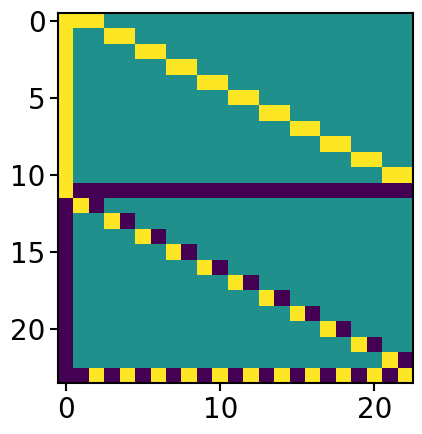

In [6]:
num_blocks_per_type = 12

block_contrasts = np.concatenate([np.ones(12), -np.ones(12)])
img_contrasts = np.concatenate([
    np.eye(num_blocks_per_type-1), -np.ones((1, num_blocks_per_type-1))
])

all_contrasts = np.ones((24,23))*np.nan

all_contrasts[:,0] = block_contrasts
all_contrasts[:num_blocks_per_type,1::2] = img_contrasts
all_contrasts[num_blocks_per_type:,1::2] = img_contrasts
all_contrasts[:num_blocks_per_type,2::2] = img_contrasts
all_contrasts[num_blocks_per_type:,2::2] = -img_contrasts

plt.imshow(all_contrasts)

## Presence of task-relevant information in the population

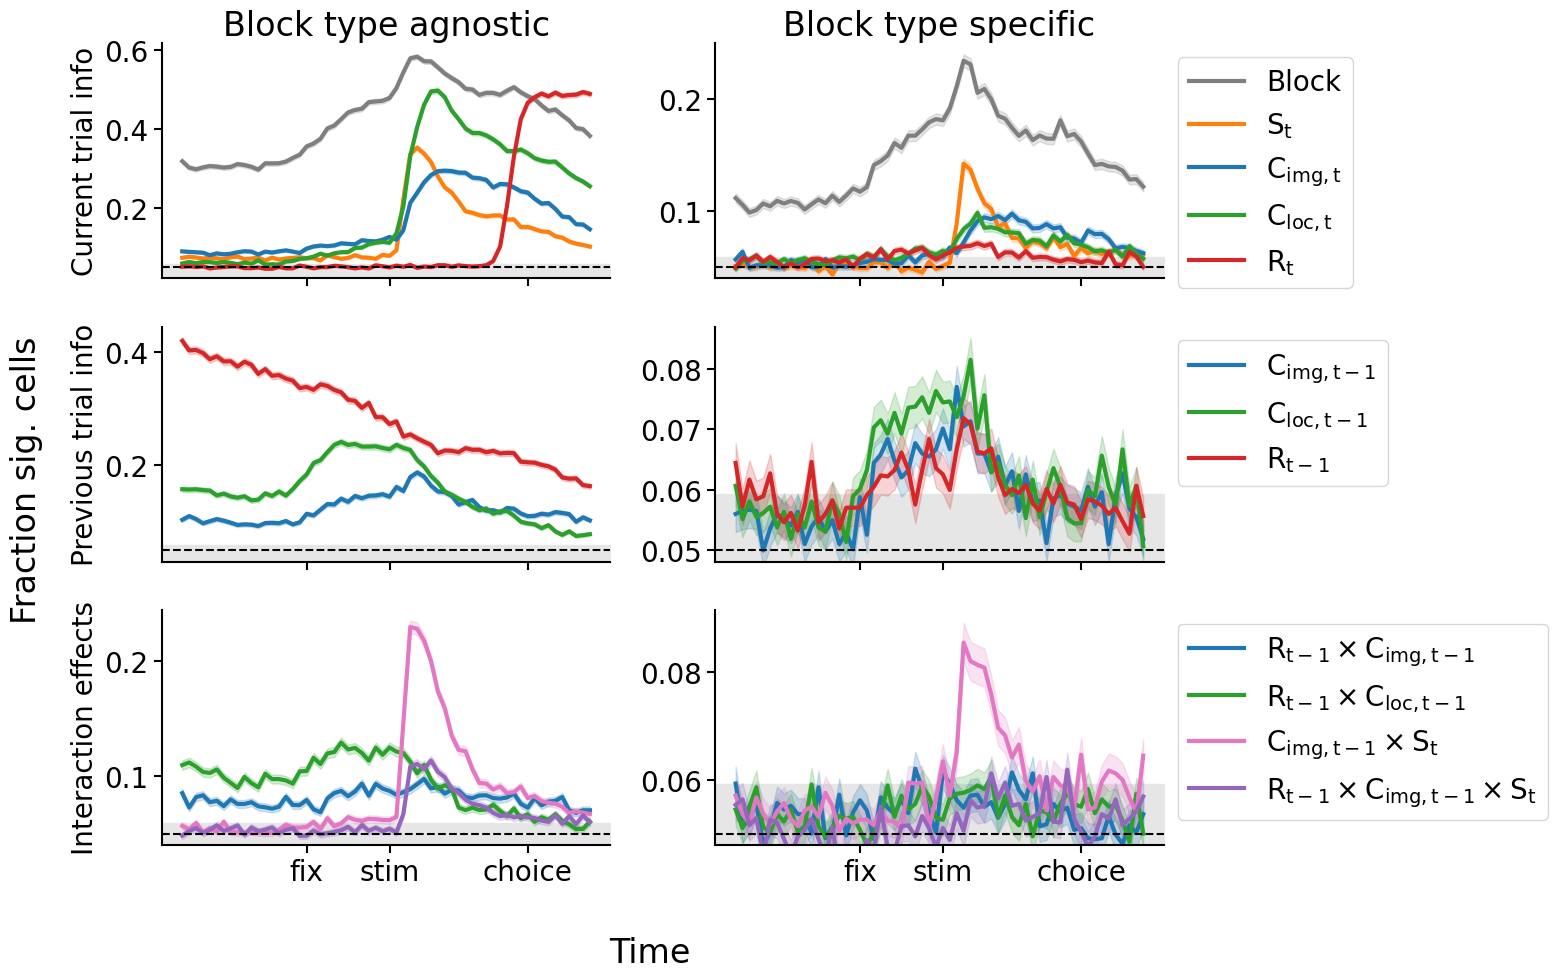

In [8]:
fig, axes = plt.subplots(3,2, sharex=True, figsize=(16, 10))

'''Current trial info'''

colors = ['tab:grey', 'tab:orange', 'tab:blue', 'tab:green', 'tab:red']

plot_mean_se(axes[0,0], xxx, all_sess_exp_var[...,2], color=colors[0], label='Block', axis=1)
plot_mean_se(axes[0,0], xxx, all_sess_exp_var[...,5], color=colors[1], label=r'$S_{t}$', axis=1)
plot_mean_se(axes[0,0], xxx, all_sess_exp_var[...,8], color=colors[2], label=r'$C_{img, t}$', axis=1)
plot_mean_se(axes[0,0], xxx, all_sess_exp_var[...,9], color=colors[3], label=r'$C_{loc, t}$', axis=1)
plot_mean_se(axes[0,0], xxx, all_sess_exp_var[...,11], color=colors[4], label=r'$R_{t}$', axis=1)


plot_mean_se(axes[0,1], xxx, all_sess_exp_var[...,1], color=colors[0], label='Block', axis=1)
plot_mean_se(axes[0,1], xxx, all_sess_exp_var[...,4], color=colors[1], label=r'$S_{t}$', axis=1)
plot_mean_se(axes[0,1], xxx, all_sess_exp_var[...,7], color=colors[2], label=r'$C_{img, t}$', axis=1)
plot_mean_se(axes[0,1], xxx, all_sess_exp_var[...,10], color=colors[3], label=r'$C_{loc, t}$', axis=1)
plot_mean_se(axes[0,1], xxx, all_sess_exp_var[...,13], color=colors[4], label=r'$R_{t}$', axis=1)

axes[0,0].set_title('Block type agnostic')
axes[0,1].set_title('Block type specific')
axes[0,0].set_ylabel('Current trial info')

# axes[0].ticklabel_format(style='sci', scilimits=(0,6), useMathText=True)
# axes[1].ticklabel_format(style='sci', scilimits=(0,6), useMathText=True)


axes[0,1].legend(bbox_to_anchor=(1., 1.))


'''Prev trial info'''

colors=['tab:blue', 'tab:green', 'tab:red']

plot_mean_se(axes[1,0], xxx, all_sess_exp_var[...,15], color=colors[0], label=r'$C_{img, t-1}$', axis=1)
plot_mean_se(axes[1,0], xxx, all_sess_exp_var[...,16], color=colors[1], label=r'$C_{loc, t-1}$', axis=1)
plot_mean_se(axes[1,0], xxx, all_sess_exp_var[...,18], color=colors[2], label=r'$R_{t-1}$', axis=1)


plot_mean_se(axes[1,1], xxx, all_sess_exp_var[...,14], color=colors[0], label=r'$C_{img, t-1}$', axis=1)
plot_mean_se(axes[1,1], xxx, all_sess_exp_var[...,17], color=colors[1], label=r'$C_{loc, t-1}$', axis=1)
plot_mean_se(axes[1,1], xxx, all_sess_exp_var[...,19], color=colors[2], label=r'$R_{t-1}$', axis=1)


axes[1,0].set_ylabel('Previous trial info')
axes[1,1].legend(bbox_to_anchor=(1., 1.))


'''Interaction effects'''

colors= ['tab:orange', 'tab:blue', 'tab:green', 'tab:pink', 'tab:purple']

# plot_mean_se(axes[2,0], xxx, all_sess_exp_var[...,29], color=colors[0], label=r'$R_{t-1}\times S_{t}$', axis=1)
plot_mean_se(axes[2,0], xxx, all_sess_exp_var[...,24], color=colors[1], 
             label=r'$R_{t-1}\times C_{img, t-1}$', axis=1)
plot_mean_se(axes[2,0], xxx, all_sess_exp_var[...,20], color=colors[2], 
             label=r'$R_{t-1}\times C_{loc, t-1}$', axis=1)
plot_mean_se(axes[2,0], xxx, all_sess_exp_var[...,25], color=colors[3], 
             label=r'$C_{img, t-1} \times S_{t}$', axis=1)
plot_mean_se(axes[2,0], xxx, all_sess_exp_var[...,30], color=colors[4], 
             label=r'$R_{t-1}\times C_{img, t-1} \times S_{t}$', axis=1)

# plot_mean_se(axes[2,1], xxx, all_sess_exp_var[...,28], color=colors[0], label=None, axis=1)
plot_mean_se(axes[2,1], xxx, all_sess_exp_var[...,23], color=colors[1], 
             label=r'$R_{t-1}\times C_{img, t-1}$', axis=1)
plot_mean_se(axes[2,1], xxx, all_sess_exp_var[...,21], color=colors[2], 
             label=r'$R_{t-1}\times C_{loc, t-1}$', axis=1)
plot_mean_se(axes[2,1], xxx, all_sess_exp_var[...,26], color=colors[3], 
             label=r'$C_{img, t-1} \times S_{t}$', axis=1)
plot_mean_se(axes[2,1], xxx, all_sess_exp_var[...,31], color=colors[4], 
             label=r'$R_{t-1}\times C_{img, t-1} \times S_{t}$', axis=1)

thresh = stats.binom.ppf(1-0.05/all_sess_exp_var.shape[0], all_sess_exp_var.shape[1], 0.05)\
                    /all_sess_exp_var.shape[1]

for a_row in axes:
    for a in a_row:
        a.axhline(0.05, ls='--', c='k')
        a.set_xticks([-600, 0, 1000], ['fix', 'stim', 'choice'])
        ylims = [0.05-(a.get_ylim()[1]-0.05)*0.05, a.get_ylim()[1]]
        a.set_ylim(ylims)
#         a.axhline(thresh, ls=':', c='k')
        xlims = a.get_xlim()
        a.fill_between(xlims, [0.0, 0.0], [thresh, thresh], color=[0.9, 0.9, 0.9], zorder=-1)
        a.set_xlim(xlims)
        


axes[2,0].set_ylabel('Interaction effects')
axes[2,1].legend(bbox_to_anchor=(1., 1.))

fig.supylabel('Fraction sig. cells')
fig.supxlabel('Time', x=0.42, y=0.01)



sns.despine()

fig.tight_layout()

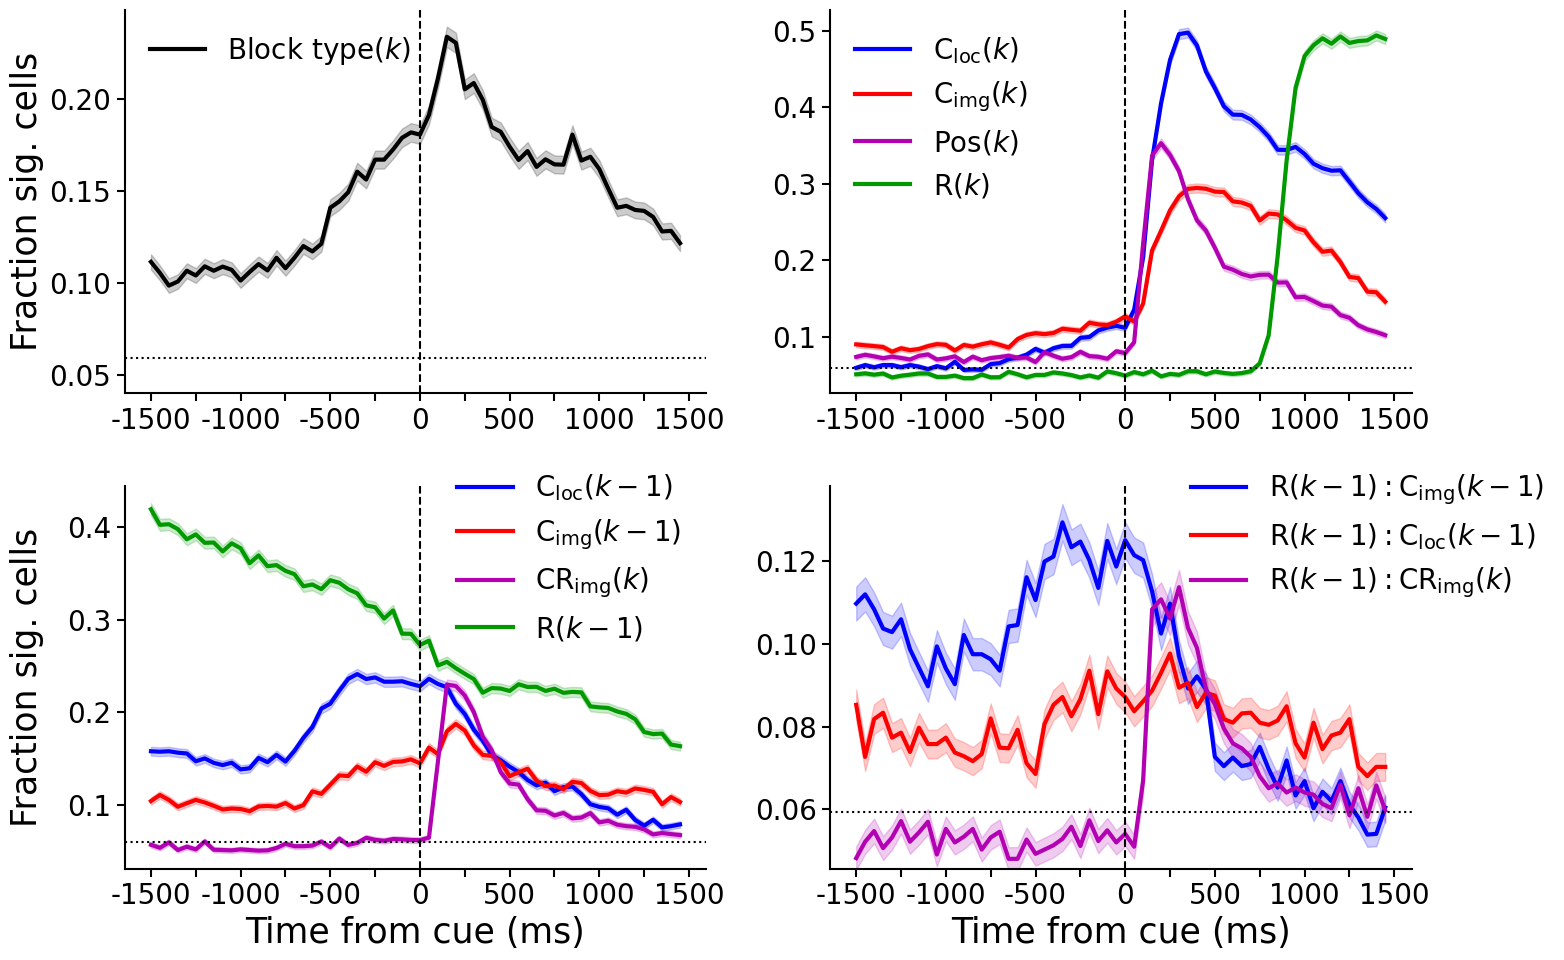

In [92]:
fig, axes = plt.subplots(2,2, figsize=(16, 10))

plot_mean_se(axes[0,0], xxx, all_sess_exp_var[...,1], color='black', label=r'$Block\ type(\mathit{k})$', axis=1)
axes[0,0].legend(loc='upper left', bbox_to_anchor=[-0.0, 1.], frameon=False, labelspacing=0.5)


plot_mean_se(axes[0,1], xxx, all_sess_exp_var[...,9], color=[0,0,1], label=r'$C_{loc}(\mathit{k})$', axis=1)
plot_mean_se(axes[0,1], xxx, all_sess_exp_var[...,8], color=[1,0,0], label=r'$C_{img}(\mathit{k})$', axis=1)
plot_mean_se(axes[0,1], xxx, all_sess_exp_var[...,5], color=[0.7, 0, 0.7], label=r'$Pos(\mathit{k})$', axis=1)
plot_mean_se(axes[0,1], xxx, all_sess_exp_var[...,11], color=[0,0.6,0], label=r'$R(\mathit{k})$', axis=1)
axes[0,1].legend(loc='upper left', bbox_to_anchor=[-0.0, 1.], frameon=False, labelspacing=0.5)


plot_mean_se(axes[1,0], xxx, all_sess_exp_var[...,16], color='blue', label=r'$C_{loc}(\mathit{k}-1)$', axis=1)
plot_mean_se(axes[1,0], xxx, all_sess_exp_var[...,15], color='red', label=r'$C_{img}(\mathit{k}-1)$', axis=1)
plot_mean_se(axes[1,0], xxx, all_sess_exp_var[...,25], color=[0.7, 0, 0.7], label=r'$CR_{img}(\mathit{k})$', axis=1)
plot_mean_se(axes[1,0], xxx, all_sess_exp_var[...,18], color=[0,0.6,0], label=r'$R(\mathit{k}-1)$', axis=1)
axes[1,0].legend(loc='upper right', bbox_to_anchor=[1, 1.1], frameon=False, labelspacing=0.5)

plot_mean_se(axes[1,1], xxx, all_sess_exp_var[...,20], color='blue', 
             label=r'$R(\mathit{k}-1): C_{img}(\mathit{k}-1)$', axis=1)
plot_mean_se(axes[1,1], xxx, all_sess_exp_var[...,24], color='red', 
             label=r'$R(\mathit{k}-1): C_{loc}(\mathit{k}-1)$', axis=1)
plot_mean_se(axes[1,1], xxx, all_sess_exp_var[...,30], color=[0.7, 0, 0.7], 
             label=r'$R(\mathit{k}-1): CR_{img}(\mathit{k})$', axis=1)
axes[1,1].legend(loc='upper right', bbox_to_anchor=[1.27, 1.1], frameon=False, labelspacing=0.5)

thresh = stats.binom.ppf(1-0.05/all_sess_exp_var.shape[0], all_sess_exp_var.shape[1], 0.05)\
                    /all_sess_exp_var.shape[1]

for a in axes.flatten():
    a.axhline(thresh, ls=':', c='k')
    a.axvline(0, ls='--', c='k')
    a.set_xticks(np.arange(-1500, 1501, 250), labels=[-1500+i//2*500  if i%2==0 else "" for i in range(13)])
    ylims = [0.05-(a.get_ylim()[1]-0.05)*0.05, a.get_ylim()[1]]
    a.set_ylim(ylims)
#         a.axhline(thresh, ls=':', c='k')
    xlims = a.get_xlim()
#         a.fill_between(xlims, [0.0, 0.0], [thresh, thresh], color=[0.9, 0.9, 0.9], zorder=-1)
    a.set_xlim(xlims)

axes[1,0].set_xlabel('Time from cue (ms)', fontsize=25)
axes[1,1].set_xlabel('Time from cue (ms)', fontsize=25)

axes[0,0].set_ylabel('Fraction sig. cells', fontsize=25)    
axes[1,0].set_ylabel('Fraction sig. cells', fontsize=25)    
    
fig.align_labels()
fig.tight_layout()
sns.despine()




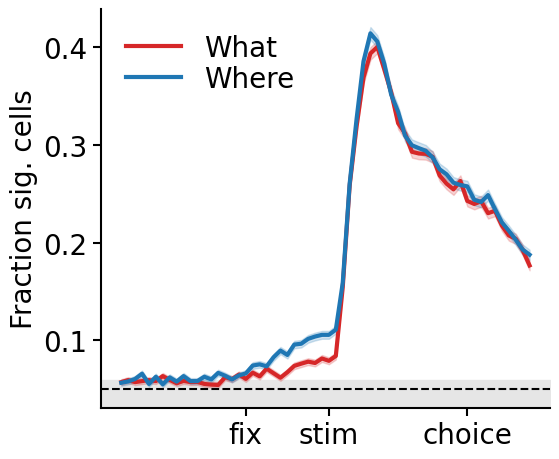

In [8]:
fig, axes = plt.subplots(1,1, sharex=True, figsize=(6, 5))

colors= ['tab:red', 'tab:blue']


plot_mean_se(axes, xxx, all_sess_contr_pvals[...,0], color=colors[0], label='What', axis=1)
plot_mean_se(axes, xxx, all_sess_contr_pvals[...,1], color=colors[1], label='Where', axis=1)

axes.legend(frameon=False, labelspacing=0.1)

axes.axhline(0.05, ls='--', c='k')
axes.set_xticks([-600, 0, 1000], ['fix', 'stim', 'choice'])
ylims = [0.05-(axes.get_ylim()[1]-0.05)*0.05, axes.get_ylim()[1]]
axes.set_ylim(ylims)
#         a.axhline(thresh, ls=':', c='k')
xlims = a.get_xlim()
axes.fill_between(xlims, [0.0, 0.0], [thresh, thresh], color=[0.9, 0.9, 0.9], zorder=-1)
axes.set_xlim(xlims)


axes.set_ylabel('Fraction sig. cells')
# axes.set_xlabel('Time')



sns.despine()

fig.tight_layout()


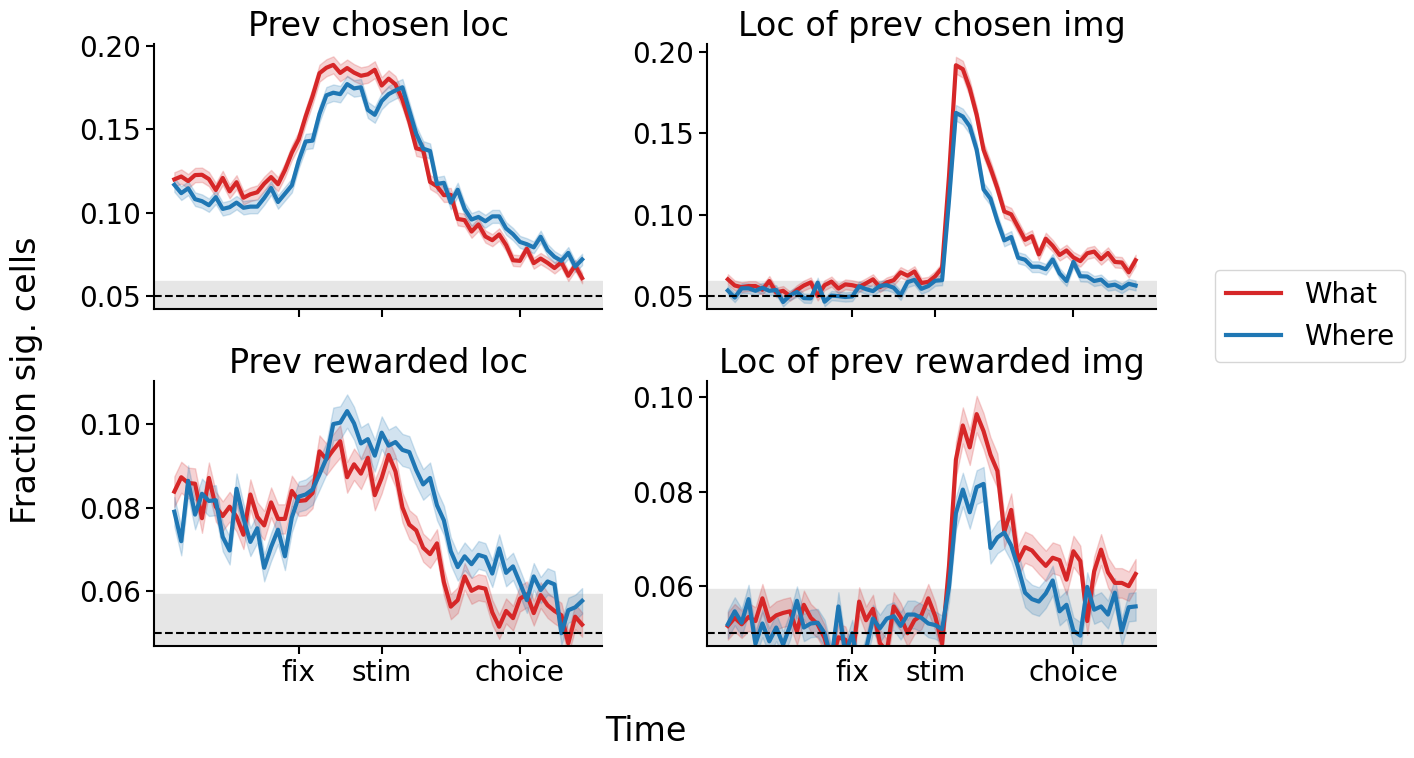

In [9]:
fig, axes = plt.subplots(2,2, sharex=True, figsize=(12, 8))

colors= ['tab:red', 'tab:blue']


plot_mean_se(axes[0,0], xxx, all_sess_contr_pvals[...,2], color=colors[0], label='What', axis=1)
plot_mean_se(axes[0,0], xxx, all_sess_contr_pvals[...,3], color=colors[1], label='Where', axis=1)
axes[0,0].set_title('Prev chosen loc')

plot_mean_se(axes[1,0], xxx, all_sess_contr_pvals[...,4], color=colors[0], label='What', axis=1)
plot_mean_se(axes[1,0], xxx, all_sess_contr_pvals[...,5], color=colors[1], label='Where', axis=1)
axes[1,0].set_title('Prev rewarded loc')

plot_mean_se(axes[0,1], xxx, all_sess_contr_pvals[...,6], color=colors[0], label='What', axis=1)
plot_mean_se(axes[0,1], xxx, all_sess_contr_pvals[...,7], color=colors[1], label='Where', axis=1)
axes[0,1].set_title('Loc of prev chosen img')

plot_mean_se(axes[1,1], xxx, all_sess_contr_pvals[...,8], color=colors[0], label='What', axis=1)
plot_mean_se(axes[1,1], xxx, all_sess_contr_pvals[...,9], color=colors[1], label='Where', axis=1)
axes[1,1].set_title('Loc of prev rewarded img')

fig.supylabel('Fraction sig. cells')
fig.supxlabel('Time', x=0.55, y=0.04)

for a_row in axes:
    for a in a_row:
        a.axhline(0.05, ls='--', c='k')
        a.set_xticks([-600, 0, 1000], ['fix', 'stim', 'choice'])
        ylims = [0.05-(a.get_ylim()[1]-0.05)*0.05, a.get_ylim()[1]]
        a.set_ylim(ylims)
#         a.axhline(thresh, ls=':', c='k')
        xlims = a.get_xlim()
        a.fill_between(xlims, [0.0, 0.0], [thresh, thresh], color=[0.9, 0.9, 0.9], zorder=-1)
        a.set_xlim(xlims)

fig.tight_layout()

axes[0,1].legend(bbox_to_anchor=(1.1, 0.2))
        
# axes[0,1].legend(loc='upper left', frameon=False, labelspacing=0.1)
        
sns.despine()




## Congruent coding of choice history

In [7]:
def plot_time_varying_correlation(xxx, yyy, ax, title, vlim=0.4, metric='corr'):        
    
    if metric=='cosine':
        sim = (xxx/np.linalg.norm(xxx, axis=-1, keepdims=True))@\
                    (yyy/np.linalg.norm(yyy, axis=-1, keepdims=True)).T
    if metric=='dot':
        sim = (xxx)@(yyy).T
    elif metric=='corr':
        sim = np.corrcoef(xxx, yyy)[:num_timesteps,num_timesteps:]
    elif metric=='cov':
        sim = np.cov(xxx, yyy)[:num_timesteps,num_timesteps:]
    elif metric=='spearman':
        sim = stats.spearmanr(xxx.T, yyy.T).statistic[:num_timesteps,num_timesteps:]
    
    
    if vlim is None:
        vlim = np.abs(sim).max()
    
    sns.heatmap(sim, 
                cmap='RdBu_r', vmin=-vlim, vmax=vlim, 
                ax=ax, square=True, cbar_kws={'shrink': 0.7})
    ax.axvline(50, ls=':', c='grey')
    ax.axhline(50, ls=':', c='grey')
    ax.axvline(30, ls=':', c='grey')
    ax.axhline(30, ls=':', c='grey')
    ax.axvline(18, ls=':', c='grey')
    ax.axhline(18, ls=':', c='grey')
    ax.set_title(title)
    ax.set_xticks([18, 30, 50], ['fix', 'stim', 'choice'], rotation=0)
    ax.set_yticks([], [])
    
    return sim


In [8]:
def p_to_asterisks(pvalue):
    if pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

def plot_pair_regressions(ax, x1, y1, x2, y2, axis_lims, xlabel, labels=[None, None]):
    
    xlims = max([np.max(np.abs(x1)), np.max(np.abs(x2))])*1.1
    ax.set_xlim([-xlims, xlims])
    ylims = max([np.max(np.abs(y1)), np.max(np.abs(y2))])*1.1
    ax.set_ylim([-ylims, ylims])

    sns.regplot(x=x1, y=y1, truncate=False, color='tab:red', scatter=False, label=labels[0], ax=ax)
    sns.regplot(x=x2, y=y2, truncate=False, color='tab:blue', scatter=False, label=labels[1], ax=ax)
    
    sns.scatterplot(x=x1, y=y1, color='tab:red', ax=ax, alpha=0.2, legend=False)
    sns.scatterplot(x=x2, y=y2, color='tab:blue', ax=ax, alpha=0.2, legend=False)
    
    r1 = stats.pearsonr(x1, y1)
    r2 = stats.pearsonr(x2, y2)
    
    zdr = (np.arctanh(r1.statistic)-np.arctanh(r2.statistic))\
                /np.sqrt(1/(x1.shape[0]-3)+1/(x2.shape[0]-3))
    
    ax.text(xlims*0.5, -ylims*0.5, f"R={np.round(r1.statistic, 2)} {p_to_asterisks(r1.pvalue)}", color='tab:red', fontsize=16)
    ax.text(xlims*0.5, -ylims*0.7, f"R={np.round(r2.statistic, 2)} {p_to_asterisks(r2.pvalue)}", color='tab:blue', fontsize=16)
    ax.text(xlims*0.5, -ylims*0.9, 
            f"$\\Delta R$={np.round(r1.statistic-r2.statistic, 2)} {p_to_asterisks(1-norm.cdf(np.abs(zdr)))}", 
            color='tab:purple', fontsize=16)
    
    ax.set_xlabel(xlabel)
    
    
    
    

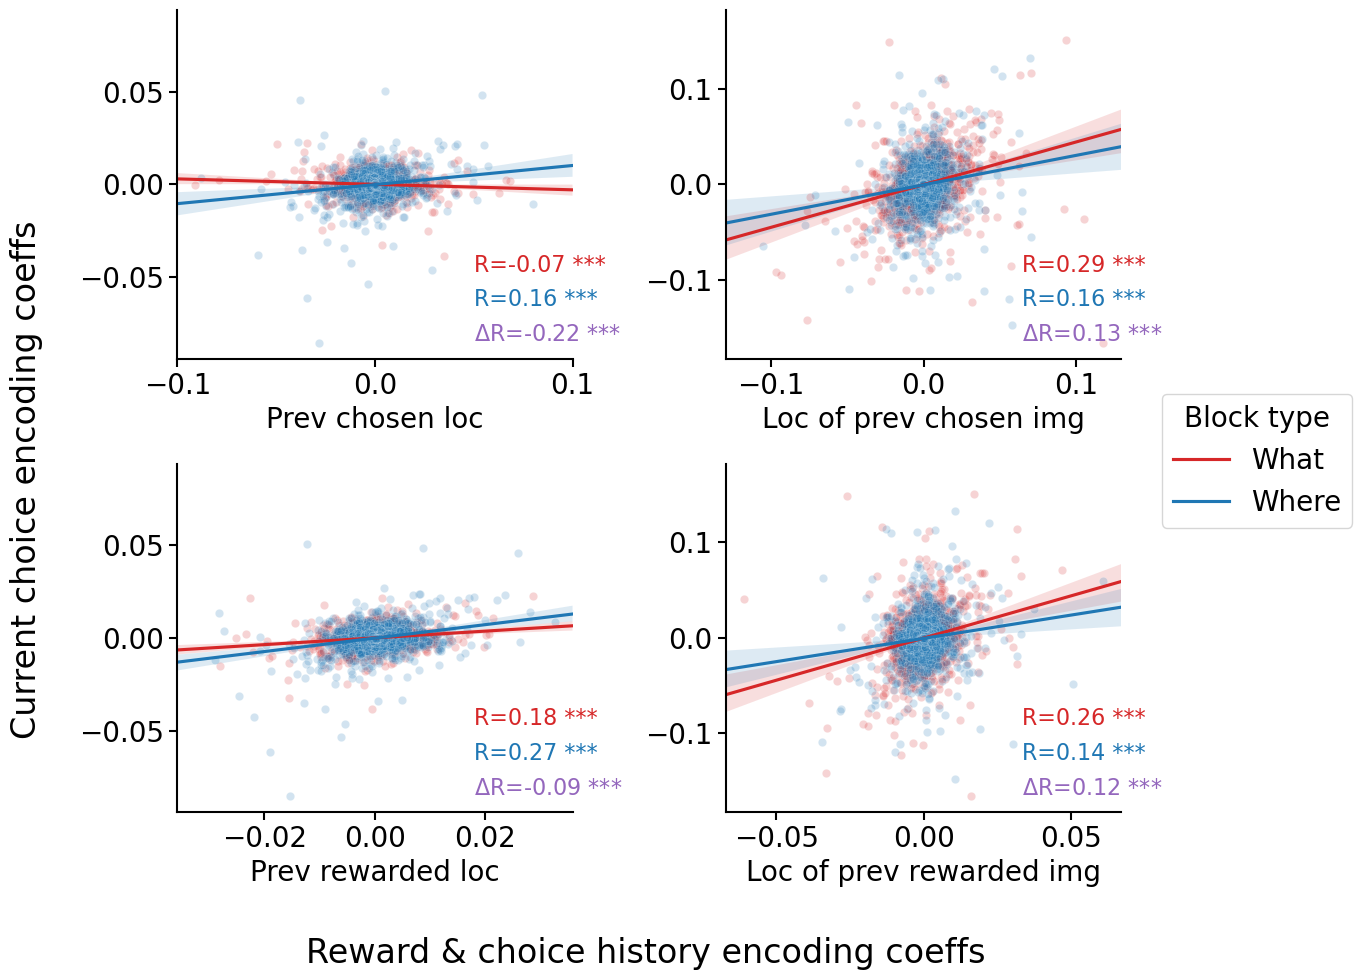

In [9]:
fig, axes = plt.subplots(2,2, figsize=(12,10))

plot_pair_regressions(axes[0,0], axis_lims=[-0.1, 0.1], xlabel='Prev chosen loc',
                      y1=(all_sess_betas[...,72]+all_sess_betas[...,73])[20:30].mean(0),
                      x1=(all_sess_betas[...,100]+all_sess_betas[...,101])[20:30].mean(0),
                      y2=(all_sess_betas[...,72]-all_sess_betas[...,73])[20:30].mean(0),
                      x2=(all_sess_betas[...,100]-all_sess_betas[...,101])[20:30].mean(0))

plot_pair_regressions(axes[1,0], axis_lims=[-0.1, 0.1], xlabel='Prev rewarded loc',
                      y1=(all_sess_betas[...,72]+all_sess_betas[...,73])[20:30].mean(0), 
                      x1=(all_sess_betas[...,104]+all_sess_betas[...,105])[20:30].mean(0),
                      y2=(all_sess_betas[...,72]-all_sess_betas[...,73])[20:30].mean(0),
                      x2=(all_sess_betas[...,104]-all_sess_betas[...,105])[20:30].mean(0))

plot_pair_regressions(axes[0,1], axis_lims=[-0.1, 0.1], xlabel='Loc of prev chosen img',
                      y1=(all_sess_betas[...,72]+all_sess_betas[...,73])[32:35].mean(0), 
                      x1=(all_sess_betas[...,130]+all_sess_betas[...,131])[32:35].mean(0),
                      y2=(all_sess_betas[...,72]-all_sess_betas[...,73])[32:35].mean(0),
                      x2=(all_sess_betas[...,130]-all_sess_betas[...,131])[32:35].mean(0))

plot_pair_regressions(axes[1,1], axis_lims=[-0.1, 0.1], xlabel='Loc of prev rewarded img',
                      y1=(all_sess_betas[...,72]+all_sess_betas[...,73])[32:35].mean(0), 
                      x1=(all_sess_betas[...,156]+all_sess_betas[...,157])[33:36].mean(0),
                      y2=(all_sess_betas[...,72]-all_sess_betas[...,73])[32:35].mean(0),
                      x2=(all_sess_betas[...,156]-all_sess_betas[...,157])[33:36].mean(0),
                     labels=['What', 'Where'])

fig.legend(bbox_to_anchor=(1.15,0.6), title='Block type')
fig.supxlabel('Reward & choice history encoding coeffs', x=0.55)
fig.supylabel('Current choice encoding coeffs')

sns.despine()
fig.tight_layout()

plt.savefig(os.path.join(figure_data_dir, "subspace_alignment.pdf"), bbox_inches='tight')

### Overall alignment of history and choice axes

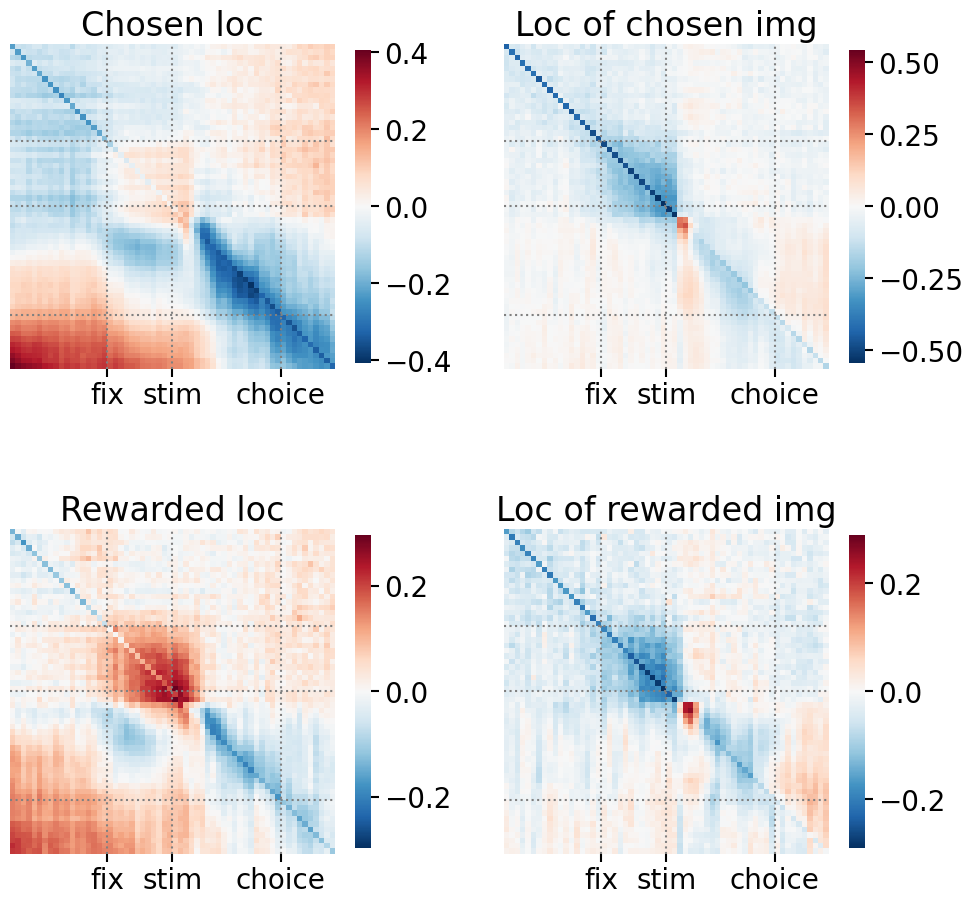

In [10]:
fig, axes = plt.subplots(2,2,figsize=(10,10))

sims_overall = []

sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,72], all_sess_betas[...,100], 
                              axes[0,0], title='Chosen loc', metric='corr', vlim=None))
sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,72], all_sess_betas[...,130], 
                              axes[0,1], title='Loc of chosen img', metric='corr', vlim=None))

sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,72], all_sess_betas[...,104], 
                              axes[1,0], title='Rewarded loc', metric='corr', vlim=None))
sims_overall.append(plot_time_varying_correlation(all_sess_betas[...,72], all_sess_betas[...,156], 
                              axes[1,1], title='Loc of rewarded img', metric='corr', vlim=None))

fig.tight_layout()


### Alignment of prev choice and wsls axes

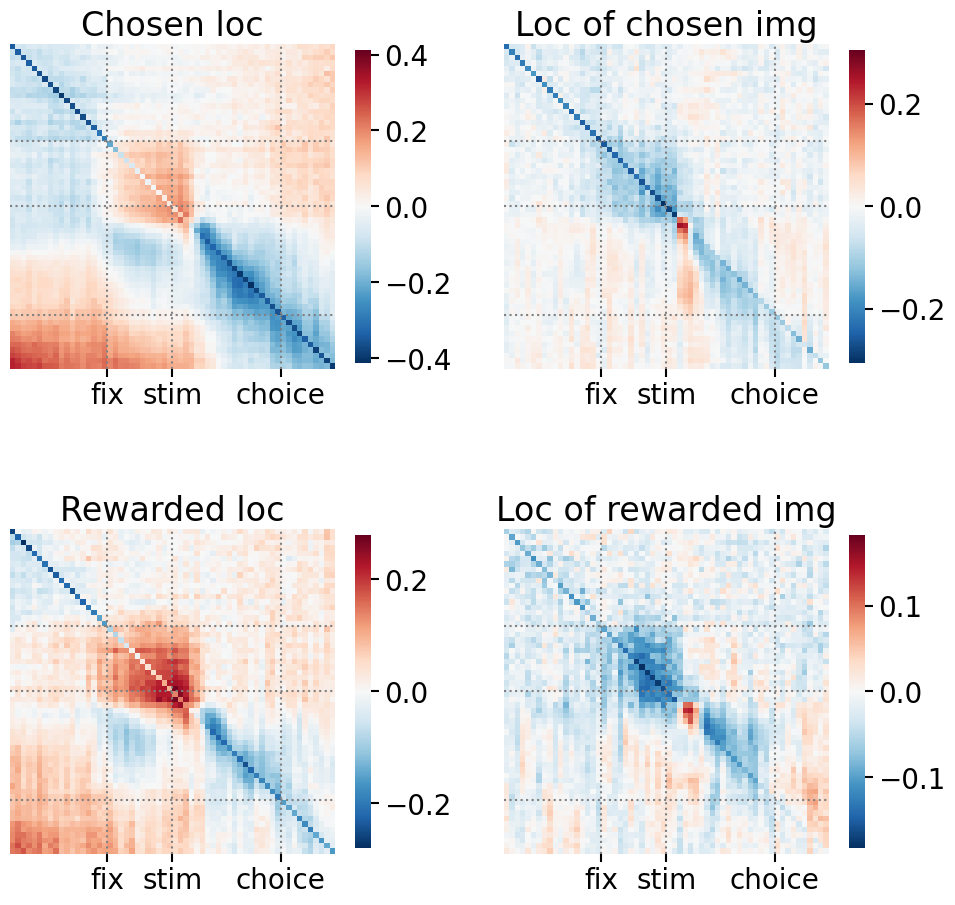

In [18]:
fig, axes = plt.subplots(2,2, figsize=(10, 10))

sims_where = []

sims_where.append(plot_time_varying_correlation(all_sess_betas[...,72]-all_sess_betas[...,73], 
                              all_sess_betas[...,100]-all_sess_betas[...,101], 
                              axes[0,0], title='Chosen loc', metric='corr', vlim=None))
sims_where.append(plot_time_varying_correlation(all_sess_betas[...,72]-all_sess_betas[...,73], 
                              all_sess_betas[...,130]-all_sess_betas[...,131], 
                              axes[0,1], title='Loc of chosen img', metric='corr', vlim=None))

sims_where.append(plot_time_varying_correlation(all_sess_betas[...,72]-all_sess_betas[...,73], 
                              all_sess_betas[...,104]-all_sess_betas[...,105], 
                              axes[1,0], title='Rewarded loc', metric='corr', vlim=None))
sims_where.append(plot_time_varying_correlation(all_sess_betas[...,72]-all_sess_betas[...,73], 
                              all_sess_betas[...,156]-all_sess_betas[...,157], 
                              axes[1,1], title='Loc of rewarded img', metric='corr', vlim=None))

fig.tight_layout()


### Alignment of history and choice axes in what blocks

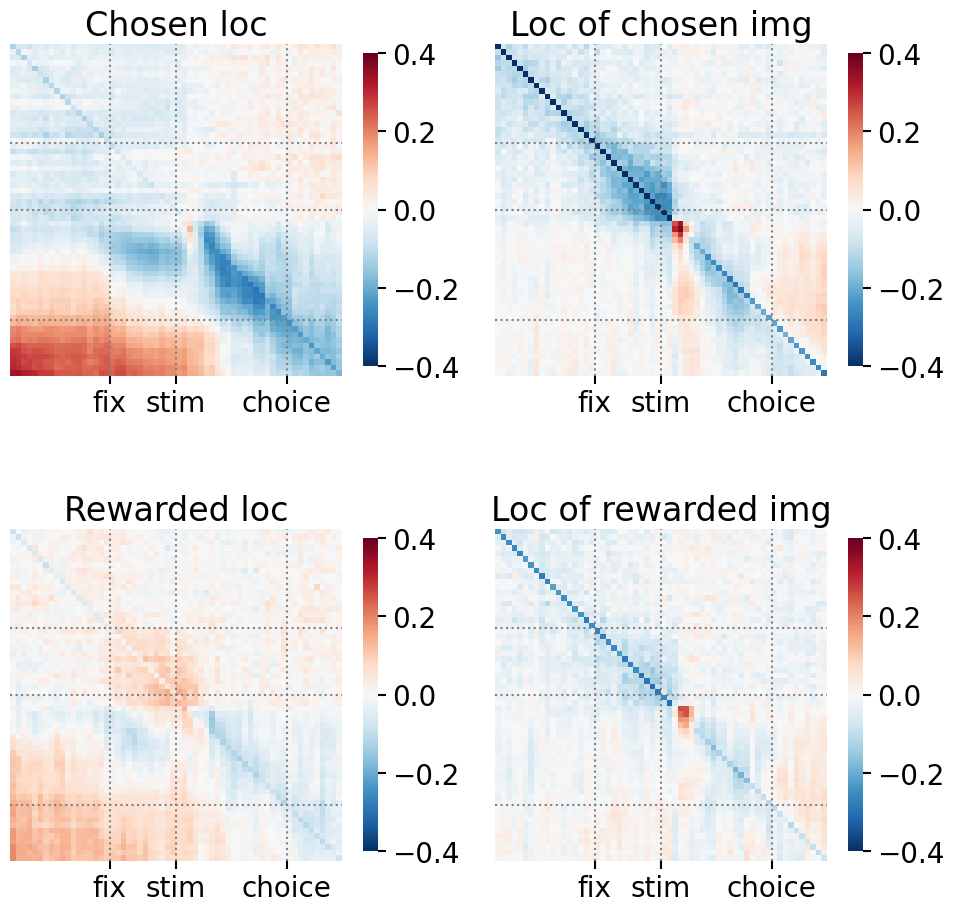

In [19]:
fig, axes = plt.subplots(2,2, figsize=(10,10))

sims_what = []

sims_what.append(plot_time_varying_correlation(all_sess_betas[...,72]+all_sess_betas[...,73], 
                              all_sess_betas[...,100]+all_sess_betas[...,101], 
                              axes[0,0], title='Chosen loc', metric='corr', vlim=0.4))
sims_what.append(plot_time_varying_correlation(all_sess_betas[...,72]+all_sess_betas[...,73], 
                              all_sess_betas[...,130]+all_sess_betas[...,131], 
                              axes[0,1], title='Loc of chosen img', metric='corr', vlim=0.4))

sims_what.append(plot_time_varying_correlation(all_sess_betas[...,72]+all_sess_betas[...,73], 
                              all_sess_betas[...,104]+all_sess_betas[...,105], 
                              axes[1,0], title='Rewarded loc', metric='corr', vlim=0.4))
sims_what.append(plot_time_varying_correlation(all_sess_betas[...,72]+all_sess_betas[...,73], 
                              all_sess_betas[...,156]+all_sess_betas[...,157], 
                              axes[1,1], title='Loc of rewarded img', metric='corr', vlim=0.4))

fig.tight_layout()

### Alignment of history and choice axes in where blocks

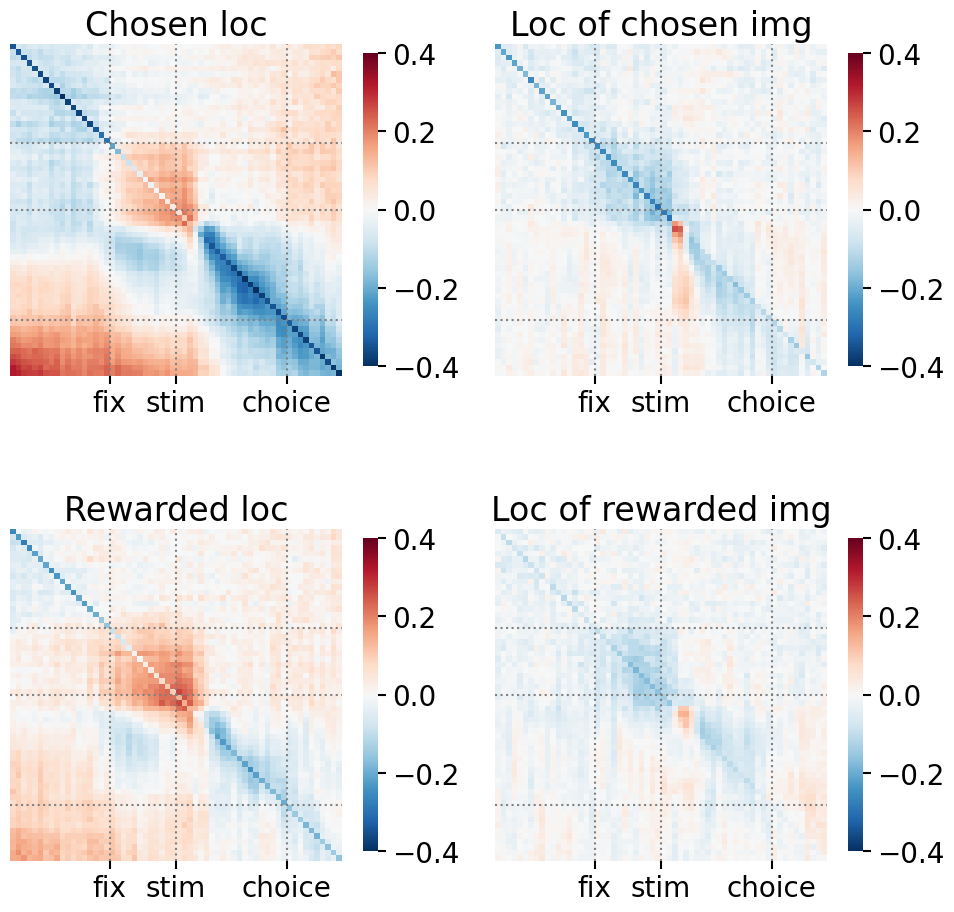

In [20]:
fig, axes = plt.subplots(2,2, figsize=(10, 10))


sims_where = []

sims_where.append(plot_time_varying_correlation(all_sess_betas[...,72]-all_sess_betas[...,73], 
                              all_sess_betas[...,100]-all_sess_betas[...,101], 
                              axes[0,0], title='Chosen loc', metric='corr', vlim=0.4))
sims_where.append(plot_time_varying_correlation(all_sess_betas[...,72]-all_sess_betas[...,73], 
                              all_sess_betas[...,130]-all_sess_betas[...,131], 
                              axes[0,1], title='Loc of chosen img', metric='corr', vlim=0.4))

sims_where.append(plot_time_varying_correlation(all_sess_betas[...,72]-all_sess_betas[...,73], 
                              all_sess_betas[...,104]-all_sess_betas[...,105], 
                              axes[1,0], title='Rewarded loc', metric='corr', vlim=0.4))
sims_where.append(plot_time_varying_correlation(all_sess_betas[...,72]-all_sess_betas[...,73], 
                              all_sess_betas[...,156]-all_sess_betas[...,157], 
                              axes[1,1], title='Loc of rewarded img', metric='corr', vlim=0.4))

fig.tight_layout()

In [38]:
all_sess_betas[...,100].shape

(60, 5820)

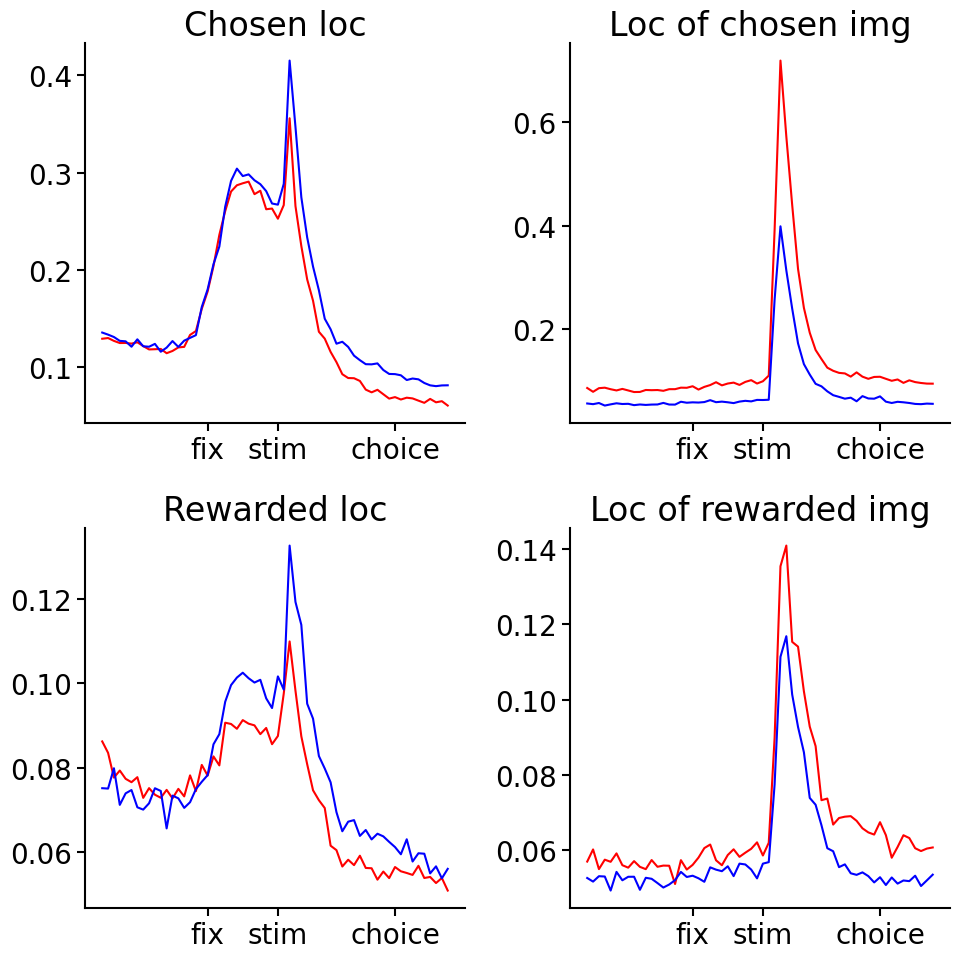

In [50]:
fig, axes = plt.subplots(2,2, figsize=(10, 10))


axes[0,0].plot(np.sum((all_sess_betas[...,100]+all_sess_betas[...,101])**2, -1), color='red')
axes[0,0].plot(np.sum((all_sess_betas[...,100]-all_sess_betas[...,101])**2, -1), color='blue')

axes[0,1].plot(np.sum((all_sess_betas[...,130]+all_sess_betas[...,131])**2, -1), color='red')
axes[0,1].plot(np.sum((all_sess_betas[...,130]-all_sess_betas[...,131])**2, -1), color='blue')


axes[1,0].plot(np.sum((all_sess_betas[...,104]+all_sess_betas[...,105])**2, -1), color='red')
axes[1,0].plot(np.sum((all_sess_betas[...,104]-all_sess_betas[...,105])**2, -1), color='blue')


axes[1,1].plot(np.sum((all_sess_betas[...,156]+all_sess_betas[...,157])**2, -1), color='red')
axes[1,1].plot(np.sum((all_sess_betas[...,156]-all_sess_betas[...,157])**2, -1), color='blue')

ylabel_names = [['Chosen loc', 'Loc of chosen img'],
                ['Rewarded loc', 'Loc of rewarded img']]

for i in range(2):
    for j in range(2):
        ax = axes[i,j]
        ax.set_title(ylabel_names[i][j])
        ax.set_xticks([18, 30, 50], ['fix', 'stim', 'choice'], rotation=0)

fig.tight_layout()
sns.despine()

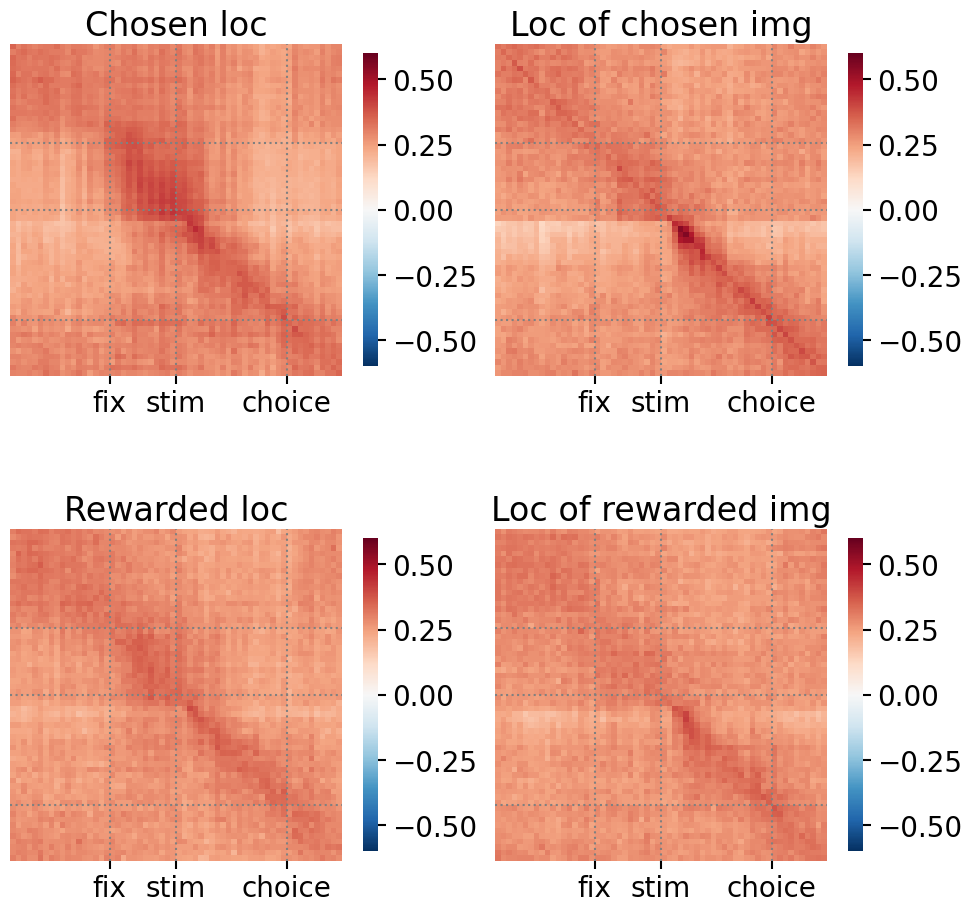

In [37]:
fig, axes = plt.subplots(2,2, figsize=(10, 10))

block_type_hist_corr = []

block_type_hist_corr.append(plot_time_varying_correlation(np.abs(all_sess_betas[...,100]), 
                              np.abs(all_sess_betas[...,101]), 
                              axes[0,0], title='Chosen loc', metric='corr', vlim=0.6))
block_type_hist_corr.append(plot_time_varying_correlation(np.abs(all_sess_betas[...,130]), 
                              np.abs(all_sess_betas[...,131]), 
                              axes[0,1], title='Loc of chosen img', metric='corr', vlim=0.6))

block_type_hist_corr.append(plot_time_varying_correlation(np.abs(all_sess_betas[...,104]), 
                              np.abs(all_sess_betas[...,105]), 
                              axes[1,0], title='Rewarded loc', metric='corr', vlim=0.6))
block_type_hist_corr.append(plot_time_varying_correlation(np.abs(all_sess_betas[...,156]), 
                              np.abs(all_sess_betas[...,157]), 
                              axes[1,1], title='Loc of rewarded img', metric='corr', vlim=0.6))

fig.tight_layout()

### Difference in alignment across blocks

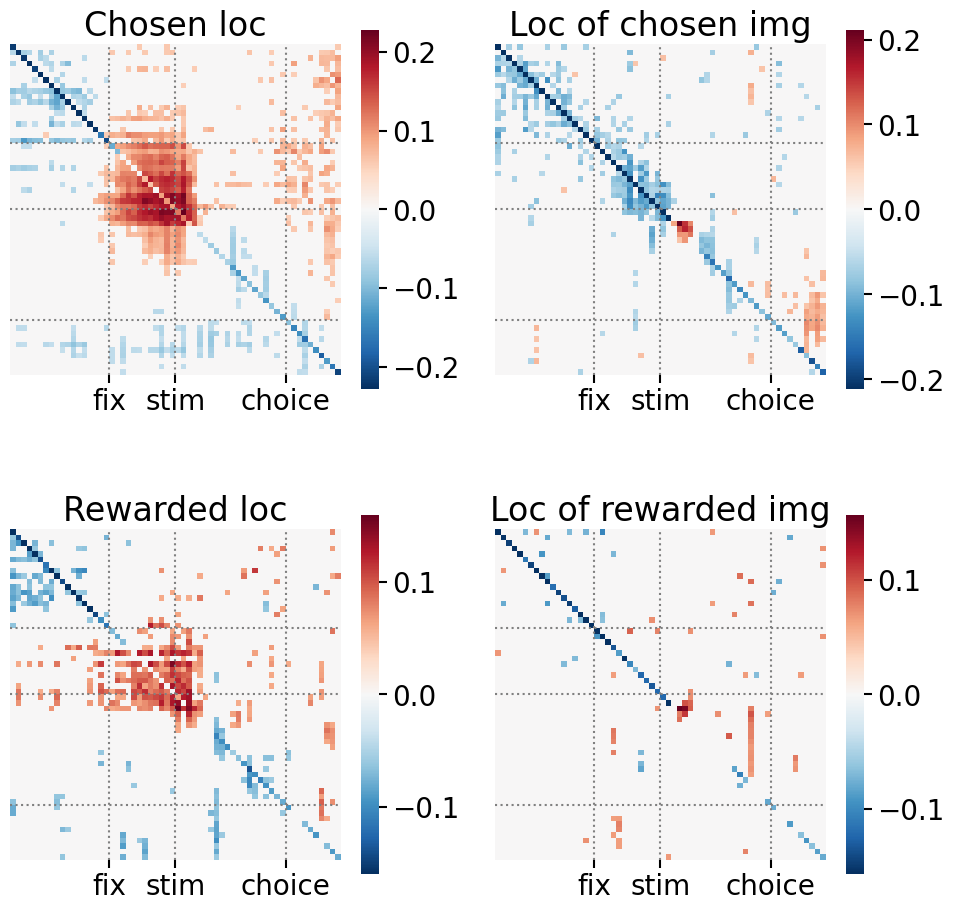

In [21]:
fig, axes = plt.subplots(2,2, figsize=(10,10))

ylabel_names = [['Chosen loc', 'Loc of chosen img'],
                ['Rewarded loc', 'Loc of rewarded img']]



n_neurons = all_sess_betas.shape[1]

for i in range(2):
    for j in range(2):
        ax = axes[i,j]
        if j==1:
            sims_diff = sims_what[i*2+j]-sims_where[i*2+j]
            sims_diff_z = (np.arctanh(sims_what[i*2+j])-np.arctanh(sims_where[i*2+j]))/np.sqrt(2/(n_neurons-3))
            sims_diff_p = 1-norm.cdf(np.abs(sims_diff_z))
        else:
            sims_diff = sims_where[i*2+j]-sims_what[i*2+j]
            sims_diff_z = (np.arctanh(sims_where[i*2+j])-np.arctanh(sims_what[i*2+j]))/np.sqrt(2/(n_neurons-3))
            sims_diff_p = 1-norm.cdf(np.abs(sims_diff_z))
            
        _,adj_p,_,_ = multipletests(sims_diff_p.reshape(60**2), method='fdr_by')
        adj_p = adj_p.reshape((60,60))
        
        vlim=np.max(sims_diff)
        
        sns.heatmap(sims_diff*(adj_p<0.05), 
                    cmap='RdBu_r', vmin=-vlim, vmax=vlim, 
                    ax=ax, square=True, cbar_kws={'shrink': 0.8})
        ax.axvline(50, ls=':', c='grey')
        ax.axhline(50, ls=':', c='grey')
        ax.axvline(30, ls=':', c='grey')
        ax.axhline(30, ls=':', c='grey')
        ax.axvline(18, ls=':', c='grey')
        ax.axhline(18, ls=':', c='grey')
        ax.set_title(ylabel_names[i][j])
        ax.set_xticks([18, 30, 50], ['fix', 'stim', 'choice'], rotation=0)
        ax.set_yticks([], [])

fig.tight_layout()

## State space representation of choice and history

In [93]:
def get_choice_history_state_space(all_sess_neural_data, all_sess_betas, all_sess_task_info,
                                    ch_axis_func, hist_axis_func, 
                                    curr_ch_func, prev_ch_func, 
                                    prev_rwd_func, block_type_func, trial_idx_func, 
                                    block_type_to_plot, prev_rwd_to_plot):
    

    results_dict = {
        'exp_vars': None, # explained variance of SVD components
        'all_axes': None, # tdr axes from SVD on regression coeffs
        'all_proj': None, # all projections stacked (number of trials X time)
        'all_task_vars': None, # all task variables associated with the projections (number of trials)
        'proj_corr': None,
    }
    
    num_sess = len(all_sess_betas)
    
    num_blocks = 24
        
    # for saving tdr axes
    all_axes_ch = []
    all_axes_hist = []
    
    # for saving projections
    all_proj_ch = []
    all_proj_hist = []
    
    # for saving singular values
    all_exp_vars_ch = []
    all_exp_vars_hist = []
    
    # for saving task conditions (curr choice, prev choice, trial number)
    all_sess_task_vars = defaultdict(list)
    
    for idx_sess in tqdm.tqdm(range(num_sess)):
        
        # center the neural data to get rid of effect of mean firing rates in projections
        centered_neural_data = \
            (all_sess_neural_data[idx_sess]-all_sess_neural_data[idx_sess].mean(0)).transpose((0,2,1))
                
        # svd on curr choice and history axes
        u1, s1, vh1 = np.linalg.svd(ch_axis_func(all_sess_betas[idx_sess]), full_matrices=False)
        u2, s2, vh2 = np.linalg.svd(hist_axis_func(all_sess_betas[idx_sess]), full_matrices=False)

        all_exp_vars_ch.append(s1)
        all_exp_vars_hist.append(s2)

        vh1 *= np.sign((u1[:,0]).sum())
        vh2 *= np.sign((u2[:,0]).sum())

        all_axes_ch.append(vh1[0])
        all_axes_hist.append(vh2[0])

        axis1 = vh1[0]
        axis2 = vh2[0]-(vh1[0]*vh2[0]).sum()*vh1[0]
        axis2 /= np.sqrt((axis2**2).sum())


        # load trial information (current trial choice, prev trial choice, prev trial reward, 
        #                         block type, trial number in block)
        curr_sess_curr_ch = curr_ch_func(all_sess_task_info[idx_sess])
        curr_sess_prev_ch = prev_ch_func(all_sess_task_info[idx_sess])
        curr_sess_prev_rwd = prev_rwd_func(all_sess_task_info[idx_sess])
        curr_sess_block_type = block_type_func(all_sess_task_info[idx_sess]).astype(int)
        curr_sess_trial_idx = trial_idx_func(all_sess_task_info[idx_sess]).astype(int)

        # select valid trials (24 blocks) and by condition (block type and previous reward)
        valid_trial_mask = all_sess_task_info[idx_sess][1:,7]<=24 
        cond_trial_mask = (curr_sess_block_type==block_type_to_plot)&(curr_sess_prev_rwd==prev_rwd_to_plot)

        # select only trials with the current block and save
        curr_sess_curr_ch = curr_sess_curr_ch[valid_trial_mask&cond_trial_mask].astype(int)
        curr_sess_prev_ch = curr_sess_prev_ch[valid_trial_mask&cond_trial_mask].astype(int)
        curr_sess_trial_idx = curr_sess_trial_idx[valid_trial_mask&cond_trial_mask].astype(int)

        curr_sess_neural_data = centered_neural_data[1:][valid_trial_mask&cond_trial_mask]

        # project onto svd axes (note that they are not necessarily orthogonal)
        proj_ch = (curr_sess_neural_data*axis1).sum(-1) # num_trials-1 X num_timestep
        proj_hist = (curr_sess_neural_data*axis2).sum(-1) # num_trials-1 X num_timestep
            
        # flip signs of projection to make consistent with encoding of regressors
        if proj_ch[curr_sess_curr_ch==1].mean()>0:
            proj_ch *= -1
            all_axes_ch[-1] *= -1

        if proj_hist[curr_sess_prev_ch==1].mean()>0:
            proj_hist *= -1
            all_axes_hist[-1] *= -1

        # collect all projections
        all_proj_ch.append(proj_ch)
        all_proj_hist.append(proj_hist)
        
        # collect all task condition variables
        all_sess_task_vars['curr_ch'].append(curr_sess_curr_ch)
        all_sess_task_vars['prev_ch'].append(curr_sess_prev_ch)
        all_sess_task_vars['trial_idx'].append(curr_sess_trial_idx)
        
    results_dict['proj_corrs'] = np.corrcoef(np.concatenate(all_proj_ch).T, np.concatenate(all_proj_hist).T)[:60,60:]
    results_dict['exp_vars'] = [np.stack(all_exp_vars_ch), np.stack(all_exp_vars_hist)]
    results_dict['all_proj'] = [all_proj_ch, all_proj_hist]
    results_dict['all_axes'] = [all_axes_ch, all_axes_hist]
    results_dict['all_task_vars'] = all_sess_task_vars
    
    return results_dict

        




    

In [9]:
results_where_dict1 = get_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x: x[...,72]+x[...,73], lambda x: (x[...,100]+x[...,101])-(x[...,104]+x[...,105]), 
    lambda x: x[1:,1], lambda x: x[:-1,1], lambda x: x[:-1,2], lambda x: x[1:,3], lambda x: x[1:,5],
    1, 0)

results_where_dict2 = get_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x: x[...,72]-x[...,73], lambda x: (x[...,100]-x[...,101])-(x[...,104]-x[...,105]), 
    lambda x: x[1:,1], lambda x: x[:-1,1], lambda x: x[:-1,2], lambda x: x[1:,3], lambda x: x[1:,5],
    2, 0)

results_where_dict3 = get_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x: x[...,72]+x[...,73], lambda x: (x[...,100]+x[...,101])+(x[...,104]+x[...,105]), 
    lambda x: x[1:,1], lambda x: x[:-1,1], lambda x: x[:-1,2], lambda x: x[1:,3], lambda x: x[1:,5],
    1, 1)

results_where_dict4 = get_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x: x[...,72]-x[...,73], lambda x: (x[...,100]-x[...,101])+(x[...,104]-x[...,105]), 
    lambda x: x[1:,1], lambda x: x[:-1,1], lambda x: x[:-1,2], lambda x: x[1:,3], lambda x: x[1:,5],
    2, 1)

results_where_dicts = [results_where_dict1,results_where_dict2,results_where_dict3,results_where_dict4]

100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


In [10]:
cr_what_func = lambda x: ((2*x[1:,0]-1)*(2*x[1:,1]-1)*(2*x[:-1,0]-1)+1)/2

results_what_dict1 = get_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x: x[...,72]+x[...,73], lambda x: (x[...,130]+x[...,131])-(x[...,156]+x[...,157]), 
    lambda x: x[1:,1], cr_what_func, lambda x: x[:-1,2], lambda x: x[1:,3], lambda x: x[1:,5],
    1, 0)

results_what_dict2 = get_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x: x[...,72]-x[...,73], lambda x: (x[...,130]-x[...,131])-(x[...,156]-x[...,157]), 
    lambda x: x[1:,1], cr_what_func, lambda x: x[:-1,2], lambda x: x[1:,3], lambda x: x[1:,5],
    2, 0)

results_what_dict3 = get_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x: x[...,72]+x[...,73], lambda x: (x[...,130]+x[...,131])+(x[...,156]+x[...,157]), 
    lambda x: x[1:,1], cr_what_func, lambda x: x[:-1,2], lambda x: x[1:,3], lambda x: x[1:,5],
    1, 1)

results_what_dict4 = get_choice_history_state_space(
    all_sess_neural_data, all_sess_regression_info['betas'], all_sess_task_info,
    lambda x: x[...,72]-x[...,73], lambda x: (x[...,130]-x[...,131])+(x[...,156]-x[...,157]), 
    lambda x: x[1:,1], cr_what_func, lambda x: x[:-1,2], lambda x: x[1:,3], lambda x: x[1:,5],
    2, 1)

results_what_dicts = [results_what_dict1,results_what_dict2,results_what_dict3,results_what_dict4]


100%|██████████| 8/8 [00:03<00:00,  2.44it/s]


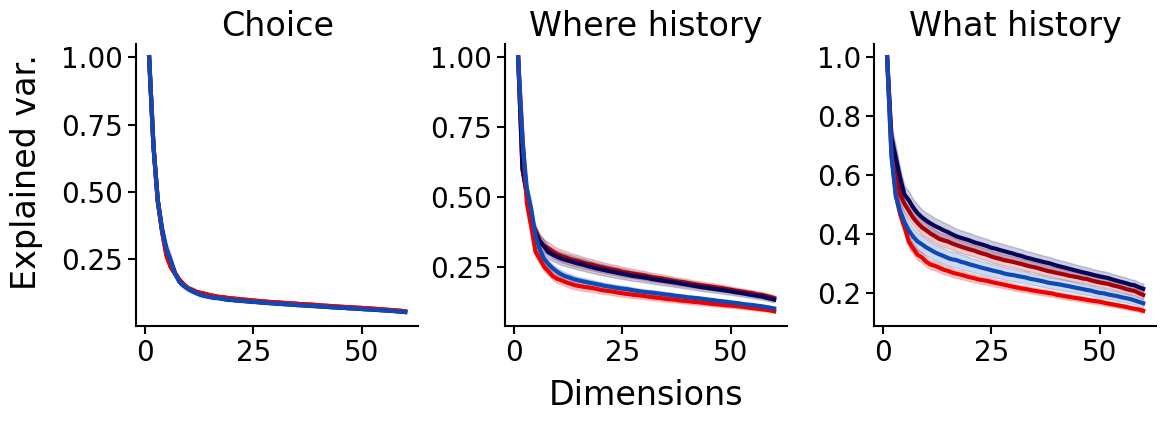

In [11]:
fig, axes = plt.subplots(1,3,figsize=(12, 4.8), sharex=True)

colors = ['#a70107', '#06065d', '#ed0101', '#0e49b5']

for idx_var in range(4):
    plot_mean_se(axes[0], np.arange(1, 61), 
                 results_what_dicts[idx_var]['exp_vars'][0]/\
                     np.max(results_what_dicts[idx_var]['exp_vars'][0], 1, keepdims=True),
                 color=colors[idx_var], label=None, axis=0)
axes[0].set_title('Choice')
    
for idx_var in range(4):
    plot_mean_se(axes[1], np.arange(1, 61), 
                 results_where_dicts[idx_var]['exp_vars'][1]/\
                     np.max(results_where_dicts[idx_var]['exp_vars'][1], 1, keepdims=True),
                 color=colors[idx_var], label=None, axis=0)
axes[1].set_title('Where history')
    
for idx_var in range(4):
    plot_mean_se(axes[2], np.arange(1, 61), 
                 results_what_dicts[idx_var]['exp_vars'][1]/\
                     np.max(results_what_dicts[idx_var]['exp_vars'][1], 1, keepdims=True),
                 color=colors[idx_var], label=None, axis=0)
axes[2].set_title('What history')

# axes[0].set_xlim([0.5, 5.05])

fig.supxlabel('Dimensions', x=0.55, y=0.1)
fig.supylabel('Explained var.', y=0.6)

sns.despine()
fig.tight_layout()


/scratch/ipykernel_2505904/21008576.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


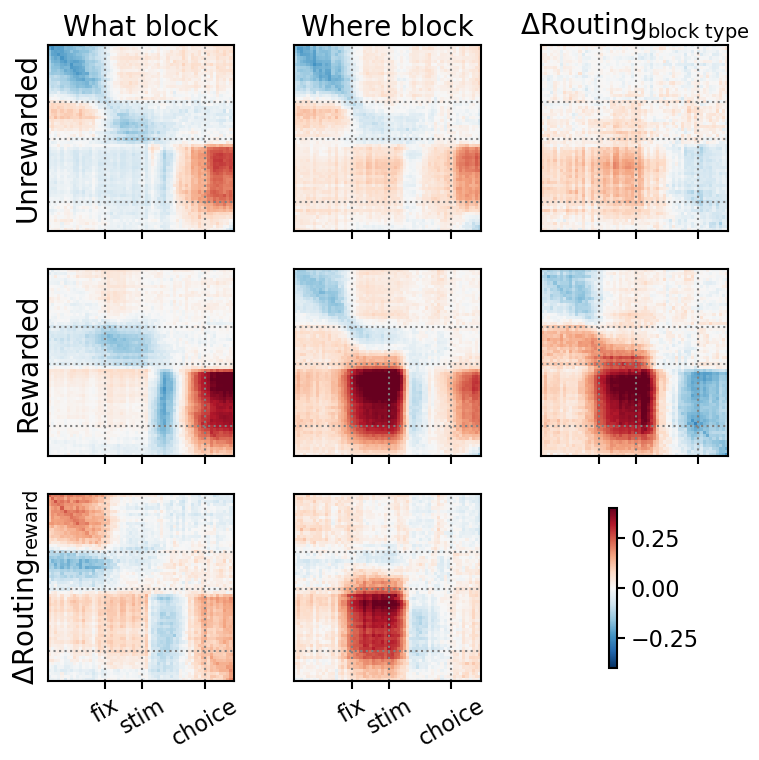

In [12]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(8,8))

im = axes[0,0].imshow(results_where_dicts[0]['proj_corrs'], norm=mpl.colors.CenteredNorm(halfrange=0.4), cmap='RdBu_r')
# fig.colorbar(im)
im = axes[0,1].imshow(results_where_dicts[1]['proj_corrs'], norm=mpl.colors.CenteredNorm(halfrange=0.4), cmap='RdBu_r')
# fig.colorbar(im)
im = axes[0,2].imshow(results_where_dicts[1]['proj_corrs']-results_where_dicts[0]['proj_corrs'],
                norm=mpl.colors.CenteredNorm(halfrange=0.4), cmap='RdBu_r')
# fig.colorbar(im)
axes[0,0].set_title('What block', fontsize=20)
axes[0,1].set_title('Where block', fontsize=20)
axes[0,2].set_title(r'$\Delta Routing_{block\ type}$', fontsize=20)


im = axes[1,0].imshow(results_where_dicts[2]['proj_corrs'], norm=mpl.colors.CenteredNorm(halfrange=0.4), cmap='RdBu_r')
# fig.colorbar(im)
im = axes[1,1].imshow(results_where_dicts[3]['proj_corrs'], norm=mpl.colors.CenteredNorm(halfrange=0.4), cmap='RdBu_r')
# fig.colorbar(im)
im = axes[1,2].imshow(results_where_dicts[3]['proj_corrs']-results_where_dicts[2]['proj_corrs'],
                norm=mpl.colors.CenteredNorm(halfrange=0.4), cmap='RdBu_r')
# fig.colorbar(im)


im = axes[2,0].imshow(results_where_dicts[2]['proj_corrs']-results_where_dicts[0]['proj_corrs'], 
                      norm=mpl.colors.CenteredNorm(halfrange=0.4), cmap='RdBu_r')
# fig.colorbar(im)
im = axes[2,1].imshow(results_where_dicts[3]['proj_corrs']-results_where_dicts[1]['proj_corrs'], 
                      norm=mpl.colors.CenteredNorm(halfrange=0.4), cmap='RdBu_r')

axes[2,2].remove()
cbar_ax = fig.add_axes([0.8, 0.14, 0.01, 0.2])
fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar_ax.tick_params(labelsize=16)

axes[0,0].set_ylabel('Unrewarded')
axes[1,0].set_ylabel('Rewarded')
axes[2,0].set_ylabel(r'$\Delta Routing_{reward}$')

for ax_row in range(3):
    for ax_col in range(3):
        if ax_row==2 and ax_col==2:
            continue

        ax = axes[ax_row, ax_col]
        ax.axvline(50, ls=':', c='grey')
        ax.axhline(50, ls=':', c='grey')
        ax.axvline(30, ls=':', c='grey')
        ax.axhline(30, ls=':', c='grey')
        ax.axvline(18, ls=':', c='grey')
        ax.axhline(18, ls=':', c='grey')
        ax.set_xticks([18, 30, 50], ['fix', 'stim', 'choice'], rotation=30, fontsize=16)
        ax.set_yticks([], [])
        
fig.tight_layout()

/scratch/ipykernel_2505904/38386499.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


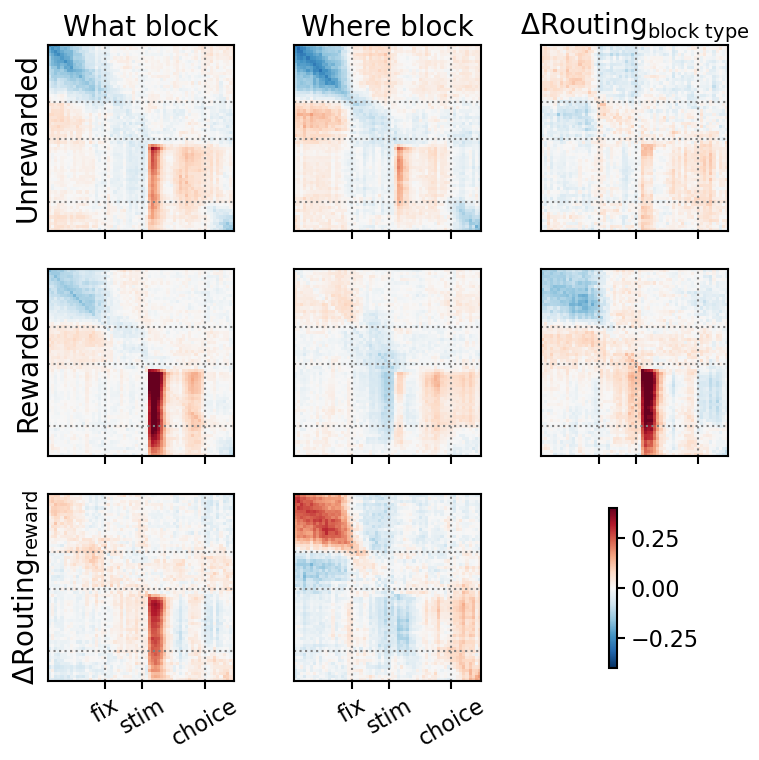

In [128]:
fig, axes = plt.subplots(3, 3, figsize=(8,8), sharex=True, sharey=True)

im = axes[0,0].imshow(results_what_dicts[0]['proj_corrs'], norm=mpl.colors.CenteredNorm(halfrange=0.4), cmap='RdBu_r')
# fig.colorbar(im)
im = axes[0,1].imshow(results_what_dicts[1]['proj_corrs'], norm=mpl.colors.CenteredNorm(halfrange=0.4), cmap='RdBu_r')
# fig.colorbar(im)
im = axes[0,2].imshow(results_what_dicts[0]['proj_corrs']-results_what_dicts[1]['proj_corrs'],
                norm=mpl.colors.CenteredNorm(halfrange=0.4), cmap='RdBu_r')
# fig.colorbar(im)
axes[0,0].set_title('What block', fontsize=20)
axes[0,1].set_title('Where block', fontsize=20)
axes[0,2].set_title(r'$\Delta Routing_{block\ type}$', fontsize=20)


im = axes[1,0].imshow(results_what_dicts[2]['proj_corrs'], norm=mpl.colors.CenteredNorm(halfrange=0.4), cmap='RdBu_r')
# fig.colorbar(im)
im = axes[1,1].imshow(results_what_dicts[3]['proj_corrs'], norm=mpl.colors.CenteredNorm(halfrange=0.4), cmap='RdBu_r')
# fig.colorbar(im)
im = axes[1,2].imshow(results_what_dicts[2]['proj_corrs']-results_what_dicts[3]['proj_corrs'],
                norm=mpl.colors.CenteredNorm(halfrange=0.4), cmap='RdBu_r')
# fig.colorbar(im)

im = axes[2,0].imshow(results_what_dicts[2]['proj_corrs']-results_what_dicts[0]['proj_corrs'], 
                      norm=mpl.colors.CenteredNorm(halfrange=0.4), cmap='RdBu_r')
# fig.colorbar(im)
im = axes[2,1].imshow(results_what_dicts[3]['proj_corrs']-results_what_dicts[1]['proj_corrs'], 
                      norm=mpl.colors.CenteredNorm(halfrange=0.4), cmap='RdBu_r')

axes[2,2].remove()
cbar_ax = fig.add_axes([0.8, 0.14, 0.01, 0.2])
fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar_ax.tick_params(labelsize=16)

axes[0,0].set_ylabel('Unrewarded')
axes[1,0].set_ylabel('Rewarded')
axes[2,0].set_ylabel(r'$\Delta Routing_{reward}$')

for ax_row in range(3):
    for ax_col in range(3):
        if ax_row==2 and ax_col==2:
            continue

        ax = axes[ax_row, ax_col]
        ax.axvline(50, ls=':', c='grey')
        ax.axhline(50, ls=':', c='grey')
        ax.axvline(30, ls=':', c='grey')
        ax.axhline(30, ls=':', c='grey')
        ax.axvline(18, ls=':', c='grey')
        ax.axhline(18, ls=':', c='grey')
        ax.set_xticks([18, 30, 50], ['fix', 'stim', 'choice'], rotation=30, fontsize=16)
        ax.set_yticks([], [])
        
fig.tight_layout()
        

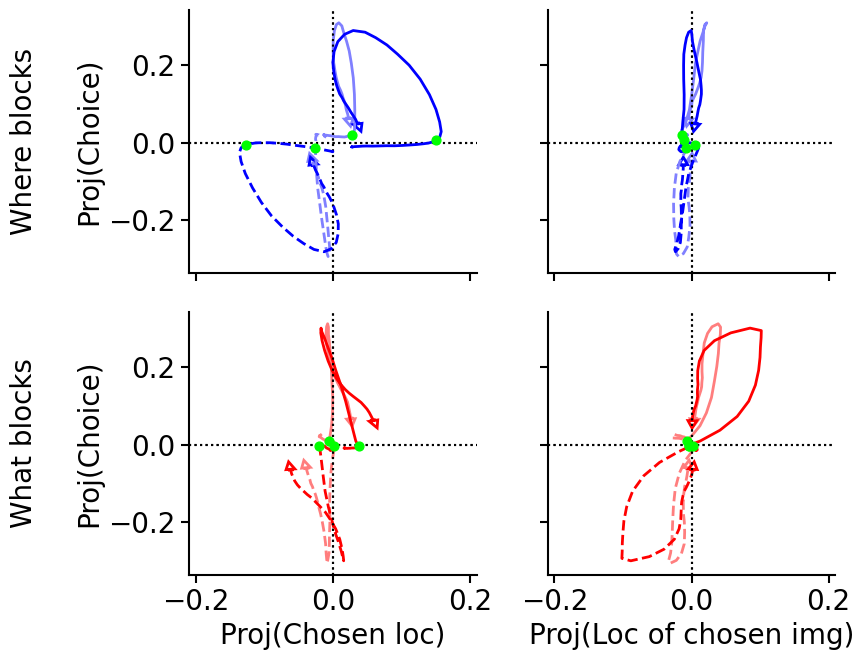

In [77]:
def plot_proj_psths_2d(all_proj, all_task_vars, ax, colors, linestyles):
    
    '''plot projection in 2d plane'''
    
    all_sess_proj_ch = np.concatenate(all_proj[0])
    all_sess_proj_hist = np.concatenate(all_proj[1])
    all_curr_ch = np.concatenate(all_task_vars['curr_ch'])
    
    w_size = 10

    for idx_curr_ch in range(2):
        curr_cond_proj_ch_avg = all_sess_proj_ch[all_curr_ch==idx_curr_ch].mean(0)
        curr_cond_proj_ch_avg = np.convolve(curr_cond_proj_ch_avg, np.ones(w_size)/w_size, mode='valid')

        curr_cond_proj_hist_avg = all_sess_proj_hist[all_curr_ch==idx_curr_ch].mean(0)
        curr_cond_proj_hist_avg = np.convolve(curr_cond_proj_hist_avg, np.ones(w_size)/w_size, mode='valid')
        
        ax.plot(curr_cond_proj_hist_avg, curr_cond_proj_ch_avg, 
                 c=colors[idx_curr_ch], lw=2, linestyle=linestyles[idx_curr_ch])
        
        ax_lims = max(max(np.abs(ax.get_xlim())), 
                      max(np.abs(ax.get_ylim())))
        
#         ax.scatter(curr_cond_proj_ch_avg[0], curr_cond_proj_hist_avg[0],
#                         s=40, c='white', edgecolors=colors[idx_curr_ch*2+idx_prev_ch], 
#                         linewidths=3, zorder=10)
        
        len_multiplier = 0.2
        ax.arrow(curr_cond_proj_hist_avg[-1], curr_cond_proj_ch_avg[-1], 
                      (curr_cond_proj_hist_avg[-1]-curr_cond_proj_hist_avg[-2])*len_multiplier,
                     (curr_cond_proj_ch_avg[-1]-curr_cond_proj_ch_avg[-2])*len_multiplier, 
                      edgecolor=colors[idx_curr_ch], facecolor='white',
                      width=ax_lims/80, lw=2)
        

        for event_idx, event_time in enumerate([30-w_size]):
            ax.scatter(curr_cond_proj_hist_avg[event_time],curr_cond_proj_ch_avg[event_time], 
                        s=40, c='lime', linewidths=1, zorder=10)
#             axes[1].arrow(curr_cond_proj_ch_avg[event_time], curr_cond_proj_hist_avg[event_time],
#                           (curr_cond_proj_ch_avg[event_time]-curr_cond_proj_ch_avg[event_time-1])*len_multiplier, 
#                           (curr_cond_proj_hist_avg[event_time]-curr_cond_proj_hist_avg[event_time-1])*len_multiplier,
#                           edgecolor=colors[idx_curr_ch*2+idx_prev_ch], facecolor='white',
#                           ls=linetyles[idx_prev_rwd], lw=3, zorder=10)
  


fig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize=(9, 7))

cmap = mpl.colormaps['bwr']
# Take colors at regular intervals spanning the colormap.
cmap = cmap(np.linspace(0, 1, 5))
colors = [[cmap[3], cmap[3]],
          [cmap[1], cmap[1]],
          [cmap[4], cmap[4]],
          [cmap[0], cmap[0]],]

linestyles =  ['-', '--']

for idx_rwd in range(2):
    for idx_block in range(2):
        plot_proj_psths_2d(results_where_dicts[idx_rwd*2+idx_block]['all_proj'], 
                           results_where_dicts[idx_rwd*2+idx_block]['all_task_vars'], 
                           axes[1-idx_block,0], colors[idx_rwd*2+idx_block], linestyles)
        plot_proj_psths_2d(results_what_dicts[idx_rwd*2+idx_block]['all_proj'], 
                           results_what_dicts[idx_rwd*2+idx_block]['all_task_vars'], 
                           axes[1-idx_block,1], colors[idx_rwd*2+idx_block], linestyles)
        axes[idx_block,1].axhline(0, color='k', linestyle=':')
        axes[idx_block,1].axvline(0, color='k', linestyle=':')

        axes[idx_block,0].axhline(0, color='k', linestyle=':')
        axes[idx_block,0].axvline(0, color='k', linestyle=':')
        
axes[0,0].set_xlim([-0.21, 0.21])
        
        
# axes[0,0].set_ylabel('Unrewarded')
# axes[1,0].set_ylabel('Rewarded')


axes[0,0].set_ylabel('Where blocks\n\nProj(Choice)', fontsize=20)
axes[1,0].set_ylabel('What blocks\n\nProj(Choice)', fontsize=20)
axes[1,0].set_xlabel('Proj(Chosen loc)', fontsize=20)
axes[1,1].set_xlabel('Proj(Loc of chosen img)', fontsize=20)

sns.despine()
fig.tight_layout()



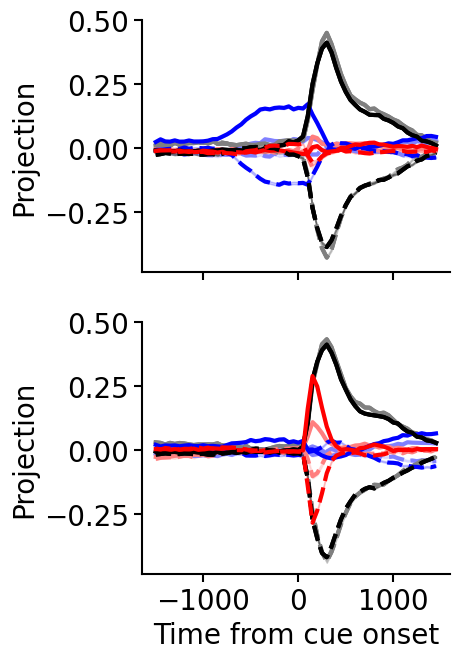

In [110]:

def plot_proj_psths_1d(all_proj, all_task_vars, ax, colors, linestyles):
    all_sess_proj_ch = np.concatenate(all_proj[0])
    all_sess_proj_hist = np.concatenate(all_proj[1])
    all_curr_ch = np.concatenate(all_task_vars['curr_ch'])
    
    for idx_curr_ch in range(2):
#         curr_cond_proj_ch_avg = .mean(0)
#         curr_cond_proj_hist_avg = all_sess_proj_hist[all_curr_ch==idx_curr_ch].mean(0)
        
        plot_mean_se(ax, xxx, all_sess_proj_ch[all_curr_ch==idx_curr_ch], 
                     colors[0], None, 0, linestyles[idx_curr_ch])
        plot_mean_se(ax, xxx, all_sess_proj_hist[all_curr_ch==idx_curr_ch], 
                     colors[1], None, 0, linestyles[idx_curr_ch])
        
#         ax.plot(xxx, curr_cond_proj_ch_avg, c=colors[0], lw=2, linestyle=linestyles[idx_curr_ch])
#         ax.plot(xxx, curr_cond_proj_hist_avg, c=colors[1], lw=2, linestyle=linestyles[idx_curr_ch])


fig, axes = plt.subplots(2,1, sharex=True, sharey=True, figsize=(5, 7))

cmap = mpl.colormaps['bwr']
# Take colors at regular intervals spanning the colormap.
cmap = cmap(np.linspace(0, 1, 5))
colors_ch = ['grey', 'k']
colors_hist_where = [cmap[1], cmap[0]]
colors_hist_what = [cmap[3], cmap[4]]
linestyles =  ['-', '--']

for idx_rwd in range(2):
    for idx_block in range(2):
        plot_proj_psths_1d(results_where_dicts[idx_rwd*2+idx_block]['all_proj'], 
                           results_where_dicts[idx_rwd*2+idx_block]['all_task_vars'], 
                           axes[1-idx_block], [colors_ch[idx_rwd], colors_hist_where[idx_rwd]], linestyles)
        plot_proj_psths_1d(results_what_dicts[idx_rwd*2+idx_block]['all_proj'], 
                           results_what_dicts[idx_rwd*2+idx_block]['all_task_vars'], 
                           axes[1-idx_block], [colors_ch[idx_rwd], colors_hist_what[idx_rwd]], linestyles)
        axes[idx_block].set_ylabel('Projection')

axes[-1].set_xlabel('Time from cue onset')
        
sns.despine()
fig.tight_layout()

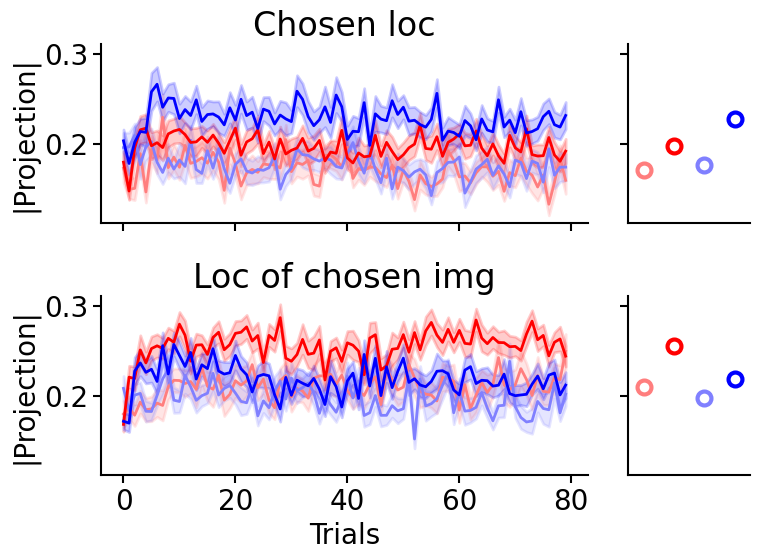

In [266]:
def plot_trialwise_abs_proj(all_proj, all_task_vars, axes, color, time_window, bar_x):
    all_sess_proj_hist = np.concatenate(all_proj[1])
    all_trial_idxs = np.concatenate(all_task_vars['trial_idx'])
    
    all_trial_proj = []
    
    for idx_curr_trial in range(1,81):
        abs_proj = np.abs(all_sess_proj_hist[all_trial_idxs==idx_curr_trial][:,time_window]).mean(1)
        all_trial_proj.append([abs_proj.mean(), 
                               abs_proj.std()/np.sqrt(np.sum(all_trial_idxs==idx_curr_trial)+1e-6)])

    all_trial_proj = np.stack(all_trial_proj)
    
    axes[0].plot(all_trial_proj[:,0], c=color, lw=2)
    axes[0].fill_between(np.arange(80), all_trial_proj[:,0]-all_trial_proj[:,1],
                   all_trial_proj[:,0]+all_trial_proj[:,1], color=color, lw=2, alpha=0.2)
    
    axes[1].scatter(bar_x, np.abs(all_sess_proj_hist)[:,time_window].mean(), 
                    edgecolor=color, facecolor='w',
                    lw = 3, s=100, zorder=10)
    axes[1].errorbar(bar_x, np.abs(all_sess_proj_hist)[:,time_window].mean(), 
                      yerr=np.abs(all_sess_proj_hist)[:,time_window].std()/np.sqrt(np.prod(all_sess_proj_hist.shape)), 
                     color=color)



fig, axes = plt.subplots(2,2, sharex='col', sharey=True, figsize=(8, 6), width_ratios=(4,1))

cmap = mpl.colormaps['bwr']
# Take colors at regular intervals spanning the colormap.
cmap = cmap(np.linspace(0, 1, 5))
colors_ch = ['grey', 'k']
colors = [cmap[3], cmap[1], cmap[4], cmap[0]]
linestyles =  ['-', '--']


for idx_rwd in range(2):
    for idx_block in range(2):
        plot_trialwise_abs_proj(results_where_dicts[idx_rwd*2+idx_block]['all_proj'], 
                           results_where_dicts[idx_rwd*2+idx_block]['all_task_vars'], 
                           axes[0], colors[idx_rwd*2+idx_block], np.arange(25, 30),
                               idx_block*2+idx_rwd)
        plot_trialwise_abs_proj(results_what_dicts[idx_rwd*2+idx_block]['all_proj'], 
                           results_what_dicts[idx_rwd*2+idx_block]['all_task_vars'], 
                           axes[1], colors[idx_rwd*2+idx_block], np.arange(30, 35),
                               idx_block*2+idx_rwd)
        axes[idx_block,0].set_ylabel('|Projection|')

axes[0,0].set_title('Chosen loc')
axes[1,0].set_title('Loc of chosen img')
axes[0,1].set_xticks([])
axes[1,1].set_xticks([])
axes[0,1].set_xlim([-0.5, 3.5])
axes[1,1].set_xlim([-0.5, 3.5])

axes[1,0].set_xlabel('Trials')
        
sns.despine()
fig.tight_layout()

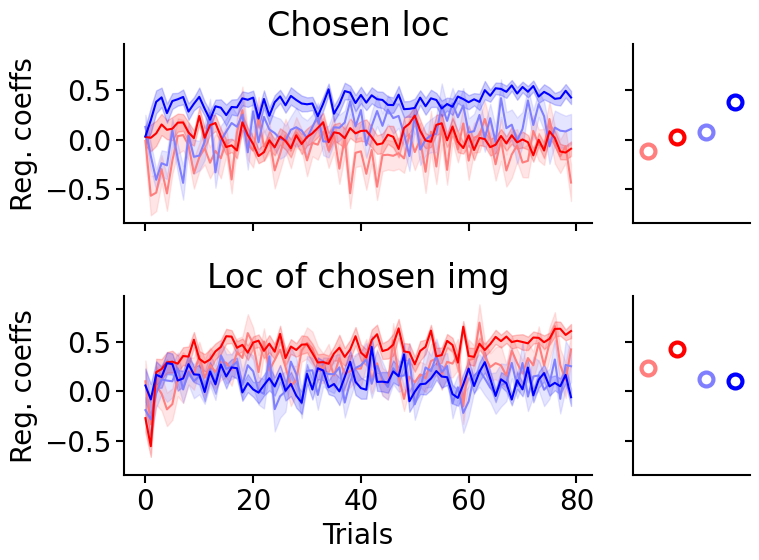

In [268]:
def plot_trialwise_proj_corr(all_proj_what, all_proj_where, all_task_vars, axes, color, 
                             time_window_ch, time_window_where, time_window_what, bar_x):
    all_sess_proj_ch = np.concatenate(all_proj_what[0])
    all_sess_proj_what_hist = np.concatenate(all_proj_what[1])
    all_sess_proj_where_hist = np.concatenate(all_proj_where[1])
    all_trial_idxs = np.concatenate(all_task_vars['trial_idx'])
    
    all_proj_corrs = []
    all_proj_corr_ses = []
    
    for idx_curr_trial in range(1,81):
        curr_trial_idx_ch_proj = \
            all_sess_proj_ch[all_trial_idxs==idx_curr_trial][:,time_window_ch].mean(1)
        curr_trial_idx_what_hist_proj = \
            all_sess_proj_what_hist[all_trial_idxs==idx_curr_trial][:,time_window_what].mean(1)
        curr_trial_idx_where_hist_proj = \
            all_sess_proj_where_hist[all_trial_idxs==idx_curr_trial][:,time_window_where].mean(1)
        
        
        mdl = sm.OLS(curr_trial_idx_ch_proj, 
                         np.stack([np.ones_like(curr_trial_idx_ch_proj),
                                   curr_trial_idx_where_hist_proj, 
                                   curr_trial_idx_what_hist_proj], 1)).fit()

        all_proj_corrs.append(mdl.params[1:])
        all_proj_corr_ses.append(mdl.bse[1:])
        
    all_proj_corrs = np.stack(all_proj_corrs)
    all_proj_corr_ses = np.stack(all_proj_corr_ses)


    for i in range(2):
        axes[i,0].plot(all_proj_corrs[:,i], color=color)
        axes[i,0].fill_between(np.arange(80), 
                             all_proj_corrs[:,i]-all_proj_corr_ses[:,i],
                             all_proj_corrs[:,i]+all_proj_corr_ses[:,i], color=color, alpha=0.2)
        
    mdl = sm.OLS(all_sess_proj_ch[:,time_window_ch].mean(1), 
                np.stack([np.ones(all_sess_proj_ch.shape[0]),
                          all_sess_proj_where_hist[:,time_window_where].mean(1),
                         all_sess_proj_what_hist[:,time_window_what].mean(1), ], 1)).fit()
    
    axes[0,1].scatter(bar_x, mdl.params[1], edgecolor=color, facecolor='w', lw=3, s=100, zorder=10)
    axes[0,1].errorbar(bar_x, mdl.params[1], yerr=mdl.bse[1], color=color)
    axes[1,1].scatter(bar_x, mdl.params[2], edgecolor=color, facecolor='w', lw=3, s=100, zorder=10)
    axes[1,1].errorbar(bar_x, mdl.params[2], yerr=mdl.bse[2], color=color)
    


fig, axes = plt.subplots(2,2, sharex='col', sharey=True, figsize=(8, 6), width_ratios=(4,1))

cmap = mpl.colormaps['bwr']
# Take colors at regular intervals spanning the colormap.
cmap = cmap(np.linspace(0, 1, 5))
colors_ch = ['grey', 'k']
colors = [cmap[3], cmap[1], cmap[4], cmap[0]]
linestyles =  ['-', '--']


for idx_rwd in range(2):
    for idx_block in range(2):
        plot_trialwise_proj_corr(results_what_dicts[idx_rwd*2+idx_block]['all_proj'], 
                                 results_where_dicts[idx_rwd*2+idx_block]['all_proj'], 
                                results_where_dicts[idx_rwd*2+idx_block]['all_task_vars'], 
                                axes, colors[idx_rwd*2+idx_block], 
                                 np.arange(30, 60), np.arange(25, 30), np.arange(30, 35),
                                idx_block*2+idx_rwd)
        axes[idx_block,0].set_ylabel('Reg. coeffs')

axes[0,0].set_title('Chosen loc')
axes[1,0].set_title('Loc of chosen img')
axes[0,1].set_xticks([])
axes[1,1].set_xticks([])
axes[0,1].set_xlim([-0.5, 3.5])
axes[1,1].set_xlim([-0.5, 3.5])

axes[1,0].set_xlabel('Trials')
        
sns.despine()
fig.tight_layout()

## Dynamic arbitration signal

In [149]:
def trialwise_subspace_alignment(neural_data, task_info, betas, betas_func, axes):
    # neural_data should be num_trials X num_neurons X num_timesteps
    # trial_indices should be num_trials
    # block_types should be num_trials
    # subspace should be num_neurons X num_timesteps
    
    num_sess = len(neural_data)
        
    num_trials, num_neurons, num_timesteps = neural_data[0].shape
    
    num_trials_per_block = np.max(task_info[0][:,5]).astype(int)
    num_blocks = 24
    timesteps_to_average = np.arange(25,35)
    
    all_sess_alignment = np.empty((num_sess, num_blocks, num_trials_per_block, num_timesteps))*np.nan
    
    all_task_proj = []
    all_sess_block_types = np.empty((num_sess, num_blocks))*np.nan
    all_sess_monkey = np.empty((num_sess, num_blocks))*np.nan
    all_sess_monkey[:4] = 0
    all_sess_monkey[4:] = 1
            
    for idx_sess in tqdm.tqdm(range(num_sess)):
        subspace = betas_func(betas[idx_sess])
        
        u, s, vh = np.linalg.svd(betas_func(betas[idx_sess]), full_matrices=False)
        vh *= np.sign((u[:,0]).sum())
        normed_subspace = vh[0,:]/(np.linalg.norm(vh[0,:], axis=0, keepdims=True)+1e-8)
        centered_neural_data = neural_data[idx_sess]-neural_data[idx_sess].mean(0)
        curr_sess_alignment = (centered_neural_data*normed_subspace[None,:,None]).sum(-2)
        
        valid_trial_masks = task_info[idx_sess][:,7]<=24
        
        block_idxs = task_info[idx_sess][valid_trial_masks,7].astype(int)-1
        trial_idxs = task_info[idx_sess][valid_trial_masks,5].astype(int)-1
        curr_sess_alignment = curr_sess_alignment[valid_trial_masks]
                
        all_sess_alignment[idx_sess, block_idxs, trial_idxs, :] = curr_sess_alignment
        all_sess_block_types[idx_sess, block_idxs] = task_info[idx_sess][valid_trial_masks,3]
        all_task_proj.append(curr_sess_alignment[1:])
    
    all_sess_alignment_flat = all_sess_alignment[:,:,:,timesteps_to_average].reshape((num_sess*num_blocks, num_trials_per_block, len(timesteps_to_average)))
    all_sess_block_types = all_sess_block_types.reshape(num_sess*num_blocks)
    all_sess_monkey = all_sess_monkey.reshape(num_sess*num_blocks)
        
        
    plot_mean_se(axes[0], np.arange(1, num_trials_per_block+1), 
                 all_sess_alignment_flat[(all_sess_block_types==1) & (all_sess_monkey==1)].mean(-1),
                 color='red', label='Monkey V, What', axis=0, linestyle='-')
    plot_mean_se(axes[0], np.arange(1, num_trials_per_block+1), 
                 all_sess_alignment_flat[(all_sess_block_types==1) & (all_sess_monkey==0)].mean(-1),
                 color='red', label='Monkey W, What', axis=0, linestyle='--')

    plot_mean_se(axes[0], np.arange(1, num_trials_per_block+1), 
                 all_sess_alignment_flat[(all_sess_block_types==2) & (all_sess_monkey==1)].mean(-1),
                 color='blue', label='Monkey V, Where', axis=0, linestyle='-')
    plot_mean_se(axes[0], np.arange(1, num_trials_per_block+1), 
                 all_sess_alignment_flat[(all_sess_block_types==2) & (all_sess_monkey==0)].mean(-1),
                 color='blue', label='Monkey W, Where', axis=0, linestyle='--')

    
    axes[0].set_xticks(np.arange(10, 80, 20), np.arange(10, 80, 20), rotation=0)
    axes[0].set_xlabel('Trial number')

    axes[0].legend(bbox_to_anchor=(0.95, 0.7), frameon=False, labelspacing=0.1, fontsize=20)
    
    cmap = mpl.colormaps['seismic']
    chunks = 8
    trials_per_chunk = 80//chunks
    colors = cmap(np.linspace(0, 1, 2*chunks))
    colors_what = colors[chunks:]
    colors_where = colors[:chunks][::-1]
        
    
    for idx_chunk in range(chunks):    
        curr_block_alignment = \
            all_sess_alignment[:,:,idx_chunk*trials_per_chunk:(idx_chunk+1)*trials_per_chunk].reshape(
                        (num_sess*num_blocks, trials_per_chunk, num_timesteps))
        
        plot_mean_se(axes[1], xxx, curr_block_alignment[(all_sess_block_types==1)].reshape(-1, num_timesteps),
                     color=colors_what[idx_chunk], axis=0, label=None)
        plot_mean_se(axes[1], xxx, curr_block_alignment[(all_sess_block_types==2)].reshape(-1, num_timesteps),
                     color=colors_where[idx_chunk], axis=0, label=None)
        
    axes[1].set_xticks([-600, 0, 1000], ['fix', 'stim', 'choice'], rotation=0)
    axes[1].set_xlabel('Timestep')
    
    cmap = mpl.colormaps['Greys']
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color=cmap((idx_chunk+0.5)/(chunks+0.5)), lw=4) for idx_chunk in range(chunks)]
    labels = [str(idx_chunk*trials_per_chunk+1)+'-'+str((idx_chunk+1)*trials_per_chunk) for idx_chunk in range(chunks)]
    
    axes[1].legend(handles=custom_lines, labels=labels, bbox_to_anchor=(1,1), frameon=False, labelspacing=0.1, title='Trial chunk')

    axes[0].set_ylabel('Projection')
    
    return all_task_proj
        

100%|██████████| 8/8 [00:03<00:00,  2.51it/s]


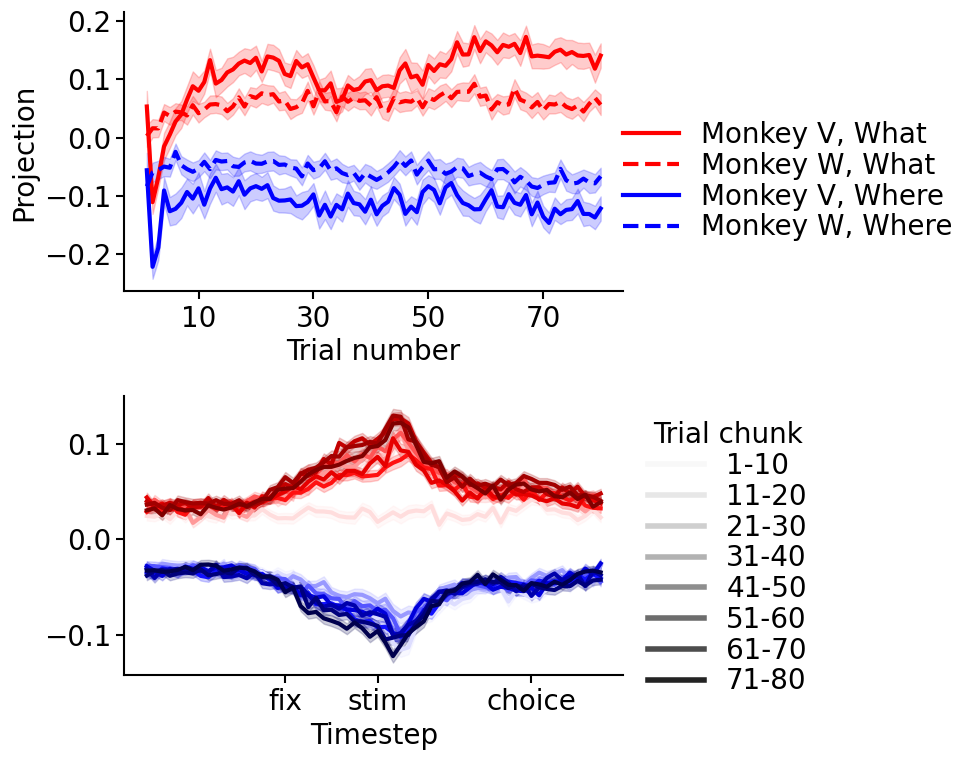

In [150]:
fig, axes = plt.subplots(2,1, figsize=(10, 8))

betas_func = lambda x: x[...,1]

all_task_proj = trialwise_subspace_alignment(all_sess_neural_data, all_sess_task_info, 
                             all_sess_regression_info['betas'],
                             betas_func, axes)

# fig.supylabel('Trial')
# fig.supxlabel('Timestep', y=0.05)
fig.tight_layout()
sns.despine()


In [143]:
def alignment_perf_corr(neural_data, task_info, betas, betas_func, axes):
    # neural_data should be num_trials X num_neurons X num_timesteps
    # trial_indices should be num_trials
    # block_types should be num_trials
    # subspace should be num_neurons X num_timesteps
    
    num_sess = len(neural_data)
    
    num_trials, num_neurons, num_timesteps = neural_data[0].shape
    
    num_blocks = 24
    
    all_sess_alignment = []
    all_sess_block_perf = []
    all_sess_block_type = []
    
    for idx_sess in tqdm.tqdm(range(num_sess)):
        subspace = betas_func(betas[idx_sess])
        
#         normed_subspace = subspace/(np.linalg.norm(subspace, axis=0, keepdims=True)+1e-8)
#         centered_neural_data = neural_data[idx_sess]-neural_data[idx_sess].mean(0)
#         curr_sess_alignment = (centered_neural_data*normed_subspace.T[None]).sum(-2)[:,25:35].mean(1) # num_trials
        
        u, s, vh = np.linalg.svd(betas_func(betas[idx_sess]), full_matrices=False)
        vh *= np.sign((u[:,0]).sum())
        normed_subspace = vh[0,:]
        centered_neural_data = neural_data[idx_sess]-neural_data[idx_sess].mean(0)
        curr_sess_alignment = (centered_neural_data*normed_subspace[None,:,None]).sum(-2)[:,25:35].mean(1)
        
        for idx_block in range(num_blocks):
            curr_trial_mask = task_info[idx_sess][:,7]==idx_block+1
            block_type = np.median(task_info[idx_sess][curr_trial_mask,3])
            all_sess_alignment.append(np.sum(curr_sess_alignment[curr_trial_mask], axis=0)/curr_trial_mask.sum())
            all_sess_block_type.append(block_type)
            all_sess_block_perf.append(np.sum(task_info[idx_sess][curr_trial_mask,6], axis=0)/curr_trial_mask.sum())        
            
        
        
    
    all_sess_alignment = np.array(all_sess_alignment)
    all_sess_block_perf = np.array(all_sess_block_perf)
    all_sess_block_type = np.array(all_sess_block_type)


    fig, ax = plt.subplots(figsize=(6, 4))
    sns.regplot(x=all_sess_alignment[all_sess_block_type==1], y=all_sess_block_perf[all_sess_block_type==1], 
                ax=ax, color='red', ci=None,
               scatter_kws={'s': 40, 'linewidths': 2, 'alpha': 0.5}, line_kws={'lw': 4, 'color': 'red'})
    sns.regplot(x=all_sess_alignment[all_sess_block_type==2], y=all_sess_block_perf[all_sess_block_type==2], 
                ax=ax, color='blue', ci=None,
               scatter_kws={'s': 40, 'linewidths': 2, 'alpha': 0.5}, line_kws={'lw': 4, 'color': 'blue'})
    ax.set_xlabel('Proj(block type)')
    ax.set_ylabel('Performance')
    sns.despine()
    
    print(stats.spearmanr(all_sess_alignment[all_sess_block_type==1], all_sess_block_perf[all_sess_block_type==1]))
    print(stats.spearmanr(all_sess_alignment[all_sess_block_type==2], all_sess_block_perf[all_sess_block_type==2]))
    
    return 


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]

SignificanceResult(statistic=np.float64(0.3701500229415684), pvalue=np.float64(0.00020566099909851373))
SignificanceResult(statistic=np.float64(-0.21726225442826366), pvalue=np.float64(0.033477445063628056))


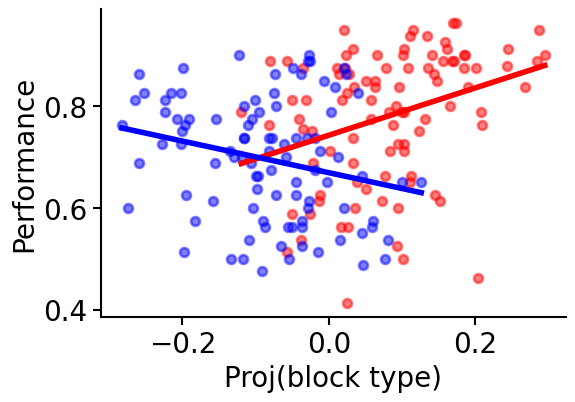

In [144]:
alignment_perf_corr(all_sess_neural_data, all_sess_task_info, all_sess_regression_info['betas'], betas_func, axes)

## Correlation between arbitration and representation strength

In [174]:
def task_belief_var_compression_routing(all_task_proj, all_hist_proj, all_ch_proj, all_sess_task_info, window):
    
    all_block_avg_hist_proj = []
    all_block_avg_task_proj = []
    all_block_hist_choice_corr = []

    for idx_sess in tqdm.tqdm(range(len(all_task_proj))):

        combined_hist_proj = np.empty_like(all_task_proj[idx_sess])
        combined_ch_proj = np.empty_like(all_task_proj[idx_sess])

        valid_trial_mask = all_sess_task_info[idx_sess][1:,7]<=24
        curr_sess_blocks_types = all_sess_task_info[idx_sess][1:,3][valid_trial_mask]
        curr_sess_prev_rwds = all_sess_task_info[idx_sess][:-1,2][valid_trial_mask]
        curr_sess_block_ids = all_sess_task_info[idx_sess][1:,7][valid_trial_mask]

        curr_cond_trials_mask = (curr_sess_blocks_types==1) & (curr_sess_prev_rwds==0)
        combined_hist_proj[curr_cond_trials_mask] = all_hist_proj[0][idx_sess]
        combined_ch_proj[curr_cond_trials_mask] = all_ch_proj[0][idx_sess]
        
        curr_cond_trials_mask = (curr_sess_blocks_types==2) & (curr_sess_prev_rwds==0)
        combined_hist_proj[curr_cond_trials_mask] = all_hist_proj[1][idx_sess]
        combined_ch_proj[curr_cond_trials_mask] = all_ch_proj[1][idx_sess]

        curr_cond_trials_mask = (curr_sess_blocks_types==1) & (curr_sess_prev_rwds==1)
        combined_hist_proj[curr_cond_trials_mask] = all_hist_proj[2][idx_sess]
        combined_ch_proj[curr_cond_trials_mask] = all_ch_proj[2][idx_sess]
        
        curr_cond_trials_mask = (curr_sess_blocks_types==2) & (curr_sess_prev_rwds==1)
        combined_hist_proj[curr_cond_trials_mask] = all_hist_proj[3][idx_sess]
        combined_ch_proj[curr_cond_trials_mask] = all_ch_proj[3][idx_sess]

        block_avg_hist_proj = np.empty((2,24))*np.nan
        block_avg_task_proj = np.empty((2,24))*np.nan
        block_avg_hist_choice_corr = np.empty((2,24))*np.nan

        for idx_rwd in range(2):
            for idx_block in range(1,25):
                cond_mask = (curr_sess_block_ids==idx_block) & (curr_sess_prev_rwds==idx_rwd)
                block_avg_hist_proj[idx_rwd, idx_block-1] = \
                    np.mean(np.abs(combined_hist_proj[cond_mask])[:,window[1][0]:window[1][1]])
                block_avg_task_proj[idx_rwd, idx_block-1] = \
                    np.mean(all_task_proj[idx_sess][cond_mask])
                block_avg_hist_choice_corr[idx_rwd, idx_block-1] = \
                    np.corrcoef(combined_ch_proj[cond_mask][:,window[0][0]:window[0][1]].mean(1), 
                                combined_hist_proj[cond_mask][:,window[1][0]:window[1][1]].mean(1))[0,1]
            
#             plt.imshow(np.corrcoef(combined_ch_proj[curr_sess_block_ids==idx_block].T, 
#                             combined_hist_proj[curr_sess_block_ids==idx_block].T)\
#                             [0:60, 60:120], cmap='bwr', norm=mpl.colors.CenteredNorm())
#             plt.show()

        all_block_avg_hist_proj.append(block_avg_hist_proj)
        all_block_avg_task_proj.append(block_avg_task_proj)
        all_block_hist_choice_corr.append(block_avg_hist_choice_corr)

    all_block_avg_hist_proj = np.stack(all_block_avg_hist_proj)
    all_block_avg_task_proj = np.stack(all_block_avg_task_proj)
    all_block_hist_choice_corr = np.stack(all_block_hist_choice_corr)

    return all_block_avg_hist_proj, all_block_avg_task_proj, all_block_hist_choice_corr


In [175]:
all_vars_avg_hist_proj = []
all_vars_avg_task_proj = []
all_vars_hist_choice_corr = []

curr_var_hist_proj, curr_var_task_proj, curr_var_hist_choice_corr = \
    task_belief_var_compression_routing(all_task_proj, 
                                        [results_where_dicts[i]['all_proj'][1] for i in range(4)],
                                        [results_where_dicts[i]['all_proj'][0] for i in range(4)], 
                                        all_sess_task_info, [[30, 60], [18, 30]])
all_vars_avg_hist_proj.append(curr_var_hist_proj)
all_vars_avg_task_proj.append(curr_var_task_proj)
all_vars_hist_choice_corr.append(curr_var_hist_choice_corr)

# curr_var_hist_proj, curr_var_task_proj, curr_var_hist_choice_corr = \
#     task_belief_var_compression_routing(all_task_proj, [results_where_dicts[2]['all_proj'][1], results_where_dicts[3]['all_proj'][1]],
#                                        [results_where_dicts[2]['all_proj'][0], results_where_dicts[3]['all_proj'][0]], 
#                                        all_sess_task_info, [[30, 60], [18, 30]])
# all_vars_avg_hist_proj.append(curr_var_hist_proj)
# all_vars_avg_task_proj.append(curr_var_task_proj)
# all_vars_hist_choice_corr.append(curr_var_hist_choice_corr)


curr_var_hist_proj, curr_var_task_proj, curr_var_hist_choice_corr = \
    task_belief_var_compression_routing(all_task_proj, 
                                       [results_what_dicts[i]['all_proj'][1] for i in range(4)],
                                       [results_what_dicts[i]['all_proj'][0] for i in range(4)], 
                                       all_sess_task_info, [[30, 60], [30, 35]])
all_vars_avg_hist_proj.append(curr_var_hist_proj)
all_vars_avg_task_proj.append(curr_var_task_proj)
all_vars_hist_choice_corr.append(curr_var_hist_choice_corr)


# curr_var_hist_proj, curr_var_task_proj, curr_var_hist_choice_corr = \
#     task_belief_var_compression_routing(all_task_proj, [results_what_dicts[2]['all_proj'][1], results_what_dicts[3]['all_proj'][1]],
#                                        [results_what_dicts[2]['all_proj'][0], results_what_dicts[3]['all_proj'][0]], 
#                                        all_sess_task_info, [[30, 60], [30, 35]])
# all_vars_avg_hist_proj.append(curr_var_hist_proj)
# all_vars_avg_task_proj.append(curr_var_task_proj)
# all_vars_hist_choice_corr.append(curr_var_hist_choice_corr)




100%|██████████| 8/8 [00:00<00:00, 187.83it/s]


SignificanceResult(statistic=np.float64(-0.14694273390662727), pvalue=np.float64(0.04196610289208729))
SignificanceResult(statistic=np.float64(-0.17800877573718907), pvalue=np.float64(0.013503132858410826))

SignificanceResult(statistic=np.float64(0.24088856034506148), pvalue=np.float64(0.0007633451242478935))
SignificanceResult(statistic=np.float64(0.2337065621354746), pvalue=np.float64(0.001104396077371006))

SignificanceResult(statistic=np.float64(-0.18436338605105393), pvalue=np.float64(0.010469793854887832))
SignificanceResult(statistic=np.float64(-0.5064393836638365), pvalue=np.float64(6.66638712829818e-14))

SignificanceResult(statistic=np.float64(0.17840042861405747), pvalue=np.float64(0.013296030550614266))
SignificanceResult(statistic=np.float64(0.41279026395030255), pvalue=np.float64(2.682911867630608e-09))



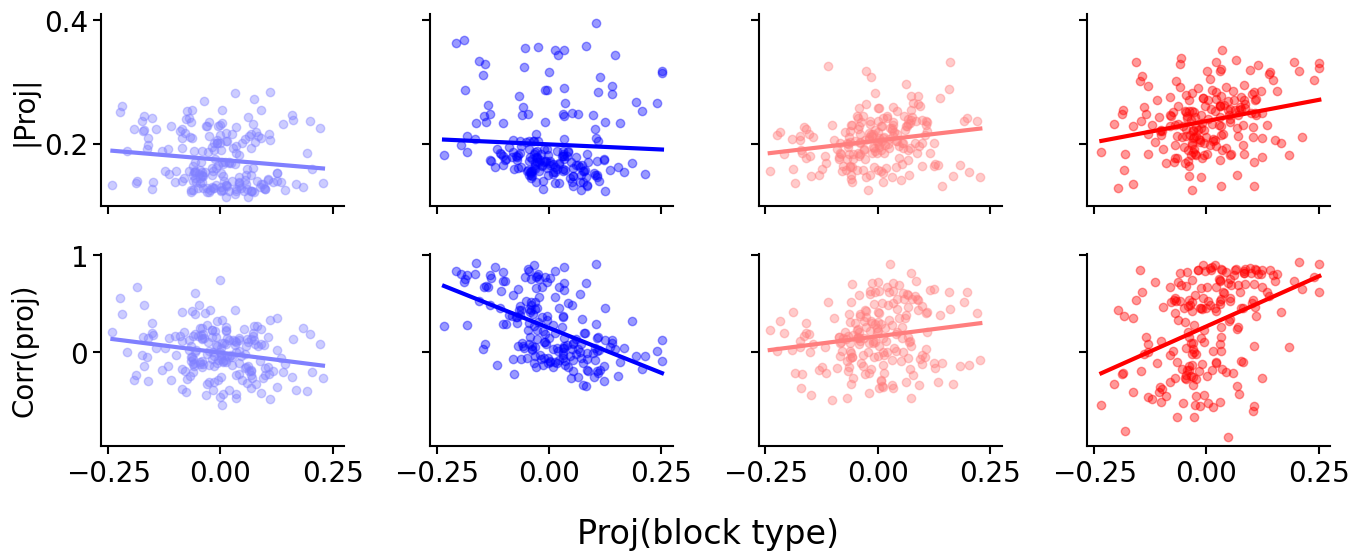

In [176]:
ylabel_names = ['Chosen loc', 'Loc of chosen img']

cmap = mpl.colormaps['bwr']
# Take colors at regular intervals spanning the colormap.
cmap = cmap(np.linspace(0, 1, 5))
colors = [cmap[1], cmap[0], cmap[3], cmap[4]]

fig, axes = plt.subplots(2,4, sharex=True, sharey='row', figsize=(14,6))


for idx_var in range(2):
    for idx_rwd in range(2):
        sns.regplot(x=all_vars_avg_task_proj[idx_var][:,idx_rwd].flatten(), 
                    y=all_vars_avg_hist_proj[idx_var][:,idx_rwd].flatten(), 
                    ax=axes[0,idx_var*2+idx_rwd], color=colors[idx_var*2+idx_rwd],
                    line_kws={'lw': 3, 'color': colors[idx_var*2+idx_rwd]}, 
                    scatter_kws={'alpha': 0.4}, ci=None)
        print(stats.spearmanr(all_vars_avg_task_proj[idx_var][:,idx_rwd].flatten(), 
                              all_vars_avg_hist_proj[idx_var][:,idx_rwd].flatten()))

#         axes[0,idx_var].set_title(ylabel_names[idx_var])
#         axes[0,idx_var].set_xticks([-0.15, 0.15], [r'$\leftarrow$ Where', r'    What $\rightarrow$'])
    print()
        

for idx_var in range(2):
    for idx_rwd in range(2):
        sns.regplot(x=all_vars_avg_task_proj[idx_var][:,idx_rwd].flatten(), 
                    y=all_vars_hist_choice_corr[idx_var][:,idx_rwd].flatten(), 
                    ax=axes[1,idx_var*2+idx_rwd], color=colors[idx_var*2+idx_rwd],
                    line_kws={'lw': 3, 'color': colors[idx_var*2+idx_rwd]}, 
                    scatter_kws={'alpha': 0.4}, ci=None)
        print(stats.spearmanr(all_vars_avg_task_proj[idx_var][:,idx_rwd].flatten(), 
                              all_vars_hist_choice_corr[idx_var][:,idx_rwd].flatten()))

#         axes[1,idx_var].set_title(ylabel_names[idx_var])
#         axes[1,idx_var].set_xticks([-0.15, 0.15], [r'$\leftarrow$ Where', r'    What $\rightarrow$'])
    print()

fig.supxlabel('Proj(block type)', x=0.52, y=0.05)
axes[0,0].set_ylabel('|Proj|')
axes[1,0].set_ylabel('Corr(proj)')
fig.align_labels()

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='grey', label='Unrewarded',
                          markerfacecolor='grey', alpha=0.8, markersize=5, ls='none'),
                  Line2D([0], [0], marker='o', color='black', label='Rewarded',
                          markerfacecolor='black', alpha=0.8, markersize=5, ls='none')]
    
# axes[1,0].legend(handles=legend_elements, bbox_to_anchor=(0.5,0.6), frameon=False, labelspacing=0.1, handletextpad=0.1)

sns.despine()
fig.tight_layout()